In [1]:
name="PbPbCE"

In [2]:
import os
import numpy as np
#import seaborn as sns
import pandas as pd
import math
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor as gpr
from sklearn.gaussian_process import kernels as krnl
import scipy.stats as st
from scipy import optimize

from multiprocessing import Pool
from multiprocessing import cpu_count

import time

### Setup working folders


In [3]:
# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "DataFiles/"

In [4]:
if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')

In [5]:
# Bounds for parametrs in the emulator are same as prior ranges so
prior_df = pd.read_csv(filepath_or_buffer="DataFiles/PbPb2760_prior", index_col=0)

In [6]:
# Design points
design = pd.read_csv(filepath_or_buffer="DataFiles/PbPb2760_design")
design_validation = pd.read_csv(filepath_or_buffer="DataFiles/PbPb2760_validation_design")

In [7]:
#Simulation outputs at the design points
simulation_df = []
validation_df = []
simulation_sd_df = []
validation_sd_df = []
for idf in range(0,4):
    simulation_df.append(pd.read_csv(filepath_or_buffer=f"DataFiles/PbPb2760_simulation_{idf}"))
    validation_df.append(pd.read_csv(filepath_or_buffer=f"DataFiles/PbPb2760_validation_{idf}"))

    #simulation_sd_df.append(pd.read_csv(filepath_or_buffer=f"DataFiles/PbPb2760_simulation_error_{idf}"))

In [8]:
df_clms=simulation_df[1].keys()

In [9]:
validation_df[3].head()

,dNch_deta[0 5],dNch_deta[ 5 10],dNch_deta[10 20],dNch_deta[20 30],dNch_deta[30 40],dNch_deta[40 50],dNch_deta[50 60],dNch_deta[60 70],dET_deta[0. 2.5],dET_deta[2.5 5. ],...,v32[10 20],v32[20 30],v32[30 40],v32[40 50],v42[0 5],v42[ 5 10],v42[10 20],v42[20 30],v42[30 40],v42[40 50]
0,1799.516327,1436.560595,1025.420578,673.696405,453.499963,276.365084,153.155151,75.324475,2183.259575,1900.166834,...,0.028013,0.031583,0.031292,0.027122,0.012486,0.012037,0.014198,0.015564,0.019148,0.018011
1,1484.931667,1265.713056,1013.013434,696.371567,486.990846,323.699832,198.970757,106.070006,1932.400399,1740.855039,...,0.028806,0.031570,0.029702,0.035635,0.009922,0.012076,0.013014,0.014217,0.015042,0.014969
2,1489.932190,1187.662937,874.433882,556.001612,341.469575,203.260931,91.649342,28.987257,1730.648444,1499.822062,...,0.031151,0.029183,0.027472,0.023971,0.011989,0.012366,0.012799,0.016811,0.017583,0.017030
3,1566.840476,1286.597500,997.221881,695.889067,467.096123,298.140385,160.852582,89.077791,2095.721024,1906.675915,...,0.024312,0.026810,0.029865,0.033346,0.010020,0.013540,0.014374,0.015877,0.015140,0.016770
4,1535.806190,1250.633294,923.374432,651.589974,454.844399,295.313393,169.491686,96.183819,1982.106401,1725.867177,...,0.027319,0.029905,0.031220,0.036091,0.011611,0.013673,0.016215,0.018221,0.019352,0.022181


### Normalize all the other models using mean and variance of observable in the PbPb 2.76 TeV Grad model

In [10]:
#normalize data with respect to lower fidelity
s_l = StandardScaler()
x = simulation_df[0].values
s_l.fit(x)
for idf in range(0,4):
    x_tmp = simulation_df[idf].values
    simulation_df[idf]= pd.DataFrame(s_l.transform(x_tmp),columns=df_clms)
    x_tmp_vl = validation_df[idf].values
    validation_df[idf]= pd.DataFrame(s_l.transform(x_tmp_vl),columns=df_clms)

#diff = np.array(prior_df.loc['max'].values - prior_df.loc['min'].values ).reshape(1,-1)
#diff_mat = np.repeat(diff,X.shape[0],axis=0)
#print(f'Shape of diff matt {diff_mat.shape}')
#X= np.divide(X,diff_mat)

In [11]:
validation_df[0].head()

,dNch_deta[0 5],dNch_deta[ 5 10],dNch_deta[10 20],dNch_deta[20 30],dNch_deta[30 40],dNch_deta[40 50],dNch_deta[50 60],dNch_deta[60 70],dET_deta[0. 2.5],dET_deta[2.5 5. ],...,v32[10 20],v32[20 30],v32[30 40],v32[40 50],v42[0 5],v42[ 5 10],v42[10 20],v42[20 30],v42[30 40],v42[40 50]
0,0.588986,0.394747,0.019567,-0.195853,-0.159802,-0.268862,-0.371815,-0.364353,0.643844,0.471012,...,0.625800,0.699832,0.498501,0.075004,0.877382,-0.016224,0.608006,0.622871,0.853867,0.716252
1,-0.021078,0.189910,0.422538,0.420411,0.627382,0.823537,0.981015,0.984654,-0.002760,0.068560,...,0.436678,0.641225,0.245146,1.023181,0.322910,-0.005227,0.158573,-0.067812,0.186990,0.094650
2,-0.505571,-0.651470,-0.778166,-1.023470,-1.200025,-1.234706,-1.503294,-1.657287,-0.415992,-0.491116,...,1.088260,0.104371,0.136631,-0.026830,0.422139,0.913847,0.470842,0.555252,0.794429,0.512711
3,0.260646,0.261774,0.332504,0.402453,0.442852,0.490003,0.217992,0.443843,0.362159,0.436056,...,0.080744,0.015078,0.311495,0.573544,0.584673,0.656860,0.437586,0.125886,0.110186,0.071801
4,0.097701,0.031697,-0.094120,0.032235,0.257156,0.352534,0.277537,0.548922,0.117066,0.004021,...,0.145601,0.326421,0.380965,0.765455,0.559257,0.763450,0.443319,0.646920,0.761677,0.915353


In [12]:
simulation_df[0].head()

,dNch_deta[0 5],dNch_deta[ 5 10],dNch_deta[10 20],dNch_deta[20 30],dNch_deta[30 40],dNch_deta[40 50],dNch_deta[50 60],dNch_deta[60 70],dET_deta[0. 2.5],dET_deta[2.5 5. ],...,v32[10 20],v32[20 30],v32[30 40],v32[40 50],v42[0 5],v42[ 5 10],v42[10 20],v42[20 30],v42[30 40],v42[40 50]
0,0.591637,0.513103,0.318624,0.271933,0.039116,-0.046547,-0.056316,-0.196780,0.312115,0.285345,...,0.264980,0.319903,0.324693,0.463557,0.106436,0.265152,0.327622,0.418780,0.429618,0.232612
1,-0.230583,-0.147812,0.027381,0.194263,-0.002001,0.081457,0.105784,0.179431,-0.536721,-0.433382,...,-0.030290,-0.272368,-0.140120,-0.342011,-0.143468,-0.347378,-0.186919,-0.368346,-0.429833,-0.506854
2,0.972523,0.963482,0.945805,0.885563,0.940180,0.949017,0.883270,0.806117,0.473958,0.514932,...,-0.666548,-0.737213,-0.796565,-0.605217,-0.379365,-0.427751,-0.886069,-0.845243,-0.812087,-0.761789
3,0.119161,0.086451,0.145753,0.281553,0.398146,0.463628,0.400291,0.308556,-0.065111,-0.033522,...,-0.852256,-0.773484,-0.507853,-0.498973,-0.687205,-0.593140,-0.518138,-0.659702,-0.545969,-0.622973
4,0.654355,0.792480,0.898200,0.836119,1.020304,1.056377,1.064235,1.049937,0.453101,0.453320,...,-0.009571,0.044080,-0.003329,0.008152,0.059327,-0.027168,-0.321039,-0.326921,-0.479888,-0.265960


In [13]:
X = design.values
X_vl = design_validation.values

In [14]:
for idf in range(0,4):
    Y = simulation_df[idf].values
    print('###########################\n for PbPb 2760')
    print( "X.shape : "+ str(X.shape) )
    print( "Y.shape : "+ str(Y.shape) )

    print('###########################\n for PbPb validation')
    Y_vl = validation_df[idf].values
    print( "X.shape : "+ str(X_vl.shape) )
    print( "Y.shape : "+ str(Y_vl.shape) )

###########################
 for PbPb 2760
X.shape : (473, 17)
Y.shape : (473, 110)
###########################
 for PbPb validation
X.shape : (86, 17)
Y.shape : (86, 110)
###########################
 for PbPb 2760
X.shape : (473, 17)
Y.shape : (473, 110)
###########################
 for PbPb validation
X.shape : (86, 17)
Y.shape : (86, 110)
###########################
 for PbPb 2760
X.shape : (473, 17)
Y.shape : (473, 110)
###########################
 for PbPb validation
X.shape : (86, 17)
Y.shape : (86, 110)
###########################
 for PbPb 2760
X.shape : (473, 17)
Y.shape : (473, 110)
###########################
 for PbPb validation
X.shape : (86, 17)
Y.shape : (86, 110)


In [15]:
#Model parameter names in Latex compatble form
model_param_dsgn = ['$N$[$2.76$TeV]',
 '$p$',
 '$\\sigma_k$',
 '$w$ [fm]',
 '$d_{\\mathrm{min}}$ [fm]',
 '$\\tau_R$ [fm/$c$]',
 '$\\alpha$',
 '$T_{\\eta,\\mathrm{kink}}$ [GeV]',
 '$a_{\\eta,\\mathrm{low}}$ [GeV${}^{-1}$]',
 '$a_{\\eta,\\mathrm{high}}$ [GeV${}^{-1}$]',
 '$(\\eta/s)_{\\mathrm{kink}}$',
 '$(\\zeta/s)_{\\max}$',
 '$T_{\\zeta,c}$ [GeV]',
 '$w_{\\zeta}$ [GeV]',
 '$\\lambda_{\\zeta}$',
 '$b_{\\pi}$',
 '$T_{\\mathrm{sw}}$ [GeV]']

In [16]:
observables_latex_2 = ['$\\frac{dN_{ch}}{d\\eta}$',
 '$\\frac{dE_T}{d\\eta}$',
 '$\\frac{dN_{\\pi}}{dy}$',
 '$\\frac{dN_{K}}{dy}$',
 '$\\frac{dN_{P}}{dy}$',
 '$\\langle pT_{\\pi} \\rangle$',
 '$\\langle pT_{K} \\rangle$',
 '$\\langle pT_{P} \\rangle$',
 '$\\frac{\\delta p_T}{\\langle p_T \\rangle}$',
 '$v_2${2}',
 '$v_3${2}',
 '$v_4${2}']

In [17]:
observables_latex_2 = ['$\\frac{dN_{ch}}{d\\eta}$',
 '$\\frac{dE_T}{d\\eta}$',
 '$\\frac{dN_{\\pi}}{dy}$',
 '$\\frac{dN_{K}}{dy}$',
 '$\\frac{dN_{P}}{dy}$',
 '$\\langle pT_{\\pi} \\rangle$',
 '$\\langle pT_{K} \\rangle$',
 '$\\langle pT_{P} \\rangle$',
 '$\\frac{\\delta p_T}{\\langle p_T \\rangle}$',
 '$v_2${2}',
 '$v_3${2}',
 '$v_4${2}']

In [18]:
observables_latex = ['$dN_{ch} / d\\eta$',
 '$dE_T / d\\eta$',
 '${dN_{\\pi}} / {dy}$',
 '${dN_{K}} / {dy}$',
 '${dN_{P}} / {dy}$',
 '$\\langle p_{T, \\pi} \\rangle$',
 '$\\langle p_{T, K} \\rangle$',
 '$\\langle p_{T, P} \\rangle$',
 '${\\delta p_T} / {\\langle p_T \\rangle}$',
 '$v_2${2}',
 '$v_3${2}',
 '$v_4${2}']

### Observables considered in this analysis

In [19]:
simulation_df[0].keys()

Index(['dNch_deta[0 5]', 'dNch_deta[ 5 10]', 'dNch_deta[10 20]',
       'dNch_deta[20 30]', 'dNch_deta[30 40]', 'dNch_deta[40 50]',
       'dNch_deta[50 60]', 'dNch_deta[60 70]', 'dET_deta[0.  2.5]',
       'dET_deta[2.5 5. ]',
       ...
       'v32[10 20]', 'v32[20 30]', 'v32[30 40]', 'v32[40 50]', 'v42[0 5]',
       'v42[ 5 10]', 'v42[10 20]', 'v42[20 30]', 'v42[30 40]', 'v42[40 50]'],
      dtype='object', length=110)

In [20]:
observables_choosen = ['dNch_deta[0 5]',
 'dNch_deta[60 70]',
 'dN_dy_pion[0 5]',
 'dN_dy_pion[60 70]',
# 'dN_dy_kaon[0 5]',
# 'dN_dy_kaon[60 70]',
# 'dN_dy_proton[0 5]',
# 'dN_dy_proton[60 70]',
 'mean_pT_pion[0 5]',
 'mean_pT_pion[60 70]',
# 'mean_pT_kaon[0 5]',
# 'mean_pT_kaon[60 70]',               
# 'mean_pT_proton[0 5]',
# 'mean_pT_proton[60 70]',
 'pT_fluct[0 5]',
 'pT_fluct[55 60]',
 'v22[0 5]',
  'v22[60 70]']

###  Build the source emulators and find length scales and white noise that we can use in multifidelity code to fix hyper parameters.

In [21]:
import GPy
import emukit.multi_fidelity
from emukit.model_wrappers.gpy_model_wrappers import GPyMultiOutputWrapper
from emukit.multi_fidelity.models import GPyLinearMultiFidelityModel
## Convert lists of arrays to ndarrays augmented with fidelity indicators
from sklearn.model_selection import train_test_split
from emukit.multi_fidelity.convert_lists_to_array import convert_x_list_to_array, convert_xy_lists_to_arrays
from sklearn.model_selection import KFold
#from emukit.multi_fidelity.models.non_linear_multi_fidelity_model import make_non_linear_kernels, NonLinearMultiFidelityModel
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib

In [60]:
GP_dic={}
n_opt = 10
n_proc=10
for selected_observable in observables_choosen:
    Y_l=simulation_df[0][selected_observable].values.reshape(-1,1)
    Y_h=simulation_df[1][selected_observable].values.reshape(-1,1)
    Y_v=validation_df[1][selected_observable].values.reshape(-1,1)
    
    x_train_h, x_test_h, y_train_h, y_test_h = X, X_vl, Y_h, Y_v
    x_train_l, y_train_l = X, Y_l
    print(selected_observable)
    kernel = GPy.kern.RBF(input_dim=17, ARD=True)
    low_gp_model = GPy.models.GPRegression(x_train_l,y_train_l, kernel)
        #high_gp_model.Gaussian_noise.fix(0)

        ## Fit the GP model
    
    low_gp_model.optimize_restarts(n_opt, verbose=True, parallel=True, num_processes=n_proc)
    print(low_gp_model)
    GP_dic[selected_observable]=low_gp_model

dNch_deta[0 5]
Optimization restart 1/10, f = -98.85516325612329
Optimization restart 2/10, f = -98.8551828335232
Optimization restart 3/10, f = -98.85421808122646
Optimization restart 4/10, f = -98.85446624649586
Optimization restart 5/10, f = -98.8551722022479
Optimization restart 6/10, f = -98.85518264113648
Optimization restart 7/10, f = -11.113525228954927
Optimization restart 8/10, f = -11.113525216670212
Optimization restart 9/10, f = -11.113525119236215
Optimization restart 10/10, f = -98.85505544885967

Name : GP regression
Objective : -98.8551828335232
Number of Parameters : 19
Number of Optimization Parameters : 19
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  rbf.variance             |     4.078759836458185  |      +ve      |        
  rbf.lengthscale          |                 (17,)  |      +ve      |        
  Gaussian_noise.variance  |  0.006799769214929973  |      +ve      |        
dNch_deta[60 70]
KeyboardIn

Process ForkPoolWorker-2120:


KeyboardInterrupt caught, calling on_optimization_end() to round things upKeyboardInterrupt caught, calling on_optimization_end() to round things up


Process ForkPoolWorker-2117:



KeyboardInterrupt caught, calling on_optimization_end() to round things up

Process ForkPoolWorker-2112:
Process ForkPoolWorker-2111:



KeyboardInterrupt caught, calling on_optimization_end() to round things up

Process ForkPoolWorker-2118:



KeyboardInterrupt caught, calling on_optimization_end() to round things up


Process ForkPoolWorker-2116:
Process ForkPoolWorker-2114:
Traceback (most recent call last):


### Transfer Learning using Emukit

In [22]:
def run_train_and_validation(x_train_s, x_train_t, x_test_t, y_train_s, y_train_t, y_test_t, obs_name):
    print('########################')
    print(obs_name)
    X_train, Y_train = convert_xy_lists_to_arrays([x_train_s, x_train_t], [y_train_s, y_train_t])
    n_opt = 10
    n_proc = 10
    
    ## Construct a linear multi-fidelity model

    #kernels = [GPy.kern.RBF(17, ARD=True), GPy.kern.RBF(17, ARD=True)]
    kernels = [GPy.kern.RBF(17, ARD=True), GPy.kern.RBF(17, ARD=True)]
    lin_tl_kernel = emukit.multi_fidelity.kernels.LinearMultiFidelityKernel(kernels)
    gpy_lin_tl_model = GPyLinearMultiFidelityModel(X_train, Y_train, lin_tl_kernel, n_fidelities=2)
    
    #Set the parameters in the Source Gaussian Process
    
    rbf_l_scales = GP_dic[obs_name].rbf.lengthscale.values
    rbf_var = GP_dic[obs_name].rbf.variance.values[0]
    wn = GP_dic[obs_name].Gaussian_noise.variance.values[0]
    
    gpy_lin_tl_model.multifidelity.rbf.lengthscale.fix(value=rbf_l_scales)
    gpy_lin_tl_model.multifidelity.rbf.variance.fix(value=rbf_var)
    gpy_lin_tl_model.mixed_noise.Gaussian_noise.fix(wn)
    #gpy_lin_mf_model.mixed_noise.Gaussian_noise_1.fix(0)


    ## Wrap the model using the given 'GPyMultiOutputWrapper'
    lin_tl_model = GPyMultiOutputWrapper(gpy_lin_tl_model, 2, n_optimization_restarts=n_opt,
                                         parallel=True, num_processes=n_proc)

    ## Fit the model
    st_l = time.time()
    lin_tl_model.optimize()
    et_l = time.time()
    
    #print("parameter array provided")
    #print(f'{rbf_l_scales} noise {wn}')
    
    if np.allclose(lin_tl_model.gpy_model.multifidelity.rbf.lengthscale.values, rbf_l_scales):
          print('RBF lengthscales are the same for low fidelity after optimization')
    if wn == lin_tl_model.gpy_model.mixed_noise.Gaussian_noise.variance.values[0]:
          print('White noise are the same after optimization')
    print('parameter array of multifidelity linear')
    print(lin_tl_model.gpy_model.param_array)
    print(f'time for linear mf optimization {et_l-st_l}')
    ## Create standard GP model using only high-fidelity data

    kernel = GPy.kern.RBF(input_dim=17, ARD=True)
    sd_gp_model = GPy.models.GPRegression(x_train_t,y_train_t, kernel)
    #high_gp_model.Gaussian_noise.fix(0)

    ## Fit the GP model
    
    sd_gp_model.optimize_restarts(n_opt, verbose=True, parallel=True, num_processes=n_proc)
    
    x_temp = convert_x_list_to_array([x_test_t,x_test_t])
    x_test_t_idf_index = x_temp[x_test_t.shape[0]:,:]
    x_test_s_idf_index = x_temp[0:x_test_t.shape[0],:]
    
    
    #Transfer learning predictions and validation score calculations
    t_mean_lin_tl_model, t_var_lin_tl_model = lin_tl_model.predict(x_test_t_idf_index)
    s_mean_lin_tl_model, s_var_lin_tl_model = lin_tl_model.predict(x_test_s_idf_index)


    print(t_mean_lin_tl_model.shape)
    r2_tl = r2_score(y_test_t,t_mean_lin_tl_model )
    mse_tl = mean_squared_error(y_test_t,t_mean_lin_tl_model )
    print(f'r2 score for multifidelity linear {r2_score(y_test_t,t_mean_lin_tl_model )}')
    print(f'mse for multifidelity linear {mean_squared_error(y_test_t,t_mean_lin_tl_model )}')

    
    # Standard GP predicitons an validation score calculation
    t_mean_sd_gp_model, t_var_sd_gp_model  = sd_gp_model.predict(x_test_t)
    print(t_mean_sd_gp_model.shape)
    r2_sdgp = r2_score(y_test_t,t_mean_sd_gp_model)
    mse_sdgp = mean_squared_error(y_test_t,t_mean_sd_gp_model )
    print(f'r2 score for standard GP {r2_score(y_test_t,t_mean_sd_gp_model)}')
    print(f'mse for standard GP {mean_squared_error(y_test_t,t_mean_sd_gp_model )}')
    
   
    lin_tl_normalized_residue = np.divide(np.array(t_mean_lin_tl_model-y_test_t).reshape(-1,1),np.sqrt(t_var_lin_tl_model.reshape(-1,1)))
   # nonlin_mf_normalize = np.divide(np.array(hf_mean_nonlin_mf_model-y_test_h).reshape(-1,1),np.sqrt(hf_var_nonlin_mf_model.reshape(-1,1))) 
    standard_gp_normalized_residue = np.divide(np.array(t_mean_sd_gp_model-y_test_t).reshape(-1,1),np.sqrt(t_var_sd_gp_model.reshape(-1,1))) 

    
    df_1 = pd.DataFrame.from_dict({'residue': lin_tl_normalized_residue.flatten(), 'name':'TL', 'obs':obs_name, 'tl_training_n':x_train_t.shape[0]})
    df_2 = pd.DataFrame.from_dict({'residue': standard_gp_normalized_residue.flatten(), 'name':'GP', 'obs':obs_name, 'tl_training_n':x_train_t.shape[0]})
    df = pd.concat(axis=0, ignore_index=True, objs=[df_1, df_2])
    #print(f'Residual Data shape {df.shape}')
    #sns.histplot(df, x="residue", hue="name", element="step", fill = True, common_norm=False, ax=ax22, legend=True)
    #ax22.legend()
    #ax22.set_title(f'Validation Residuals for {obs_name} with {x_train_h.shape[0]} training samples')
    #plt.tight_layout()
    
    r2s= [r2_tl, r2_sdgp]
    mses=[mse_tl, mse_sdgp]
    Wn = [lin_tl_model.gpy_model.param_array[-2],lin_tl_model.gpy_model.param_array[-1], sd_gp_model.param_array[-1]]
    rho = lin_tl_model.gpy_model.param_array[-3]
    return np.hstack((r2s, mses, Wn, rho)), df

#Uncoment this block if you want to run and calculate residues.



In [24]:
# residue_df = pd.DataFrame()
# n_batch = 10
# df_results = pd.DataFrame(columns=["observable", "fold","n_training","r2_lin_tl","r2_stand_GP",
#                                   "mse_lin_tl","mse_stand_GP","wn_lin_tl","wn_stand_GP","rho"])
# split_i = 0
# for selected_observable in observables_choosen:
#     start_time = time.time()
#     Y_s=simulation_df[0][selected_observable].values.reshape(-1,1)
#     Y_t=simulation_df[1][selected_observable].values.reshape(-1,1)
#     Y_v=validation_df[1][selected_observable].values.reshape(-1,1)
    
#     x_train_t, x_test_t, y_train_t, y_test_t = X, X_vl, Y_t, Y_v
#     x_train_s, y_train_s = X, Y_s
    
#     for i in range(0,n_batch):
#         if i in [0,1,2,3,4,5,6,7,8,9]:
#             l=0
#             h=(x_train_t.shape[0]//n_batch)*(i+1)
#         else:
#             continue
#         if i == n_batch-1:
#             h=x_train_t.shape[0]
#         r2_mse_wn_rho, df_tmp = run_train_and_validation(x_train_s, x_train_t[l:h,:],x_test_t, y_train_s, y_train_t[l:h,:], y_test_t, selected_observable)
#         df_results = df_results.append({
#                 "observable": selected_observable,
#                 "fold": split_i,
#                 "n_training":h,
#                 "r2_lin_mf":r2_mse_wn_rho[0],
#                 "r2_stand_GP":r2_mse_wn_rho[1],
#                 "mse_lin_mf":r2_mse_wn_rho[2],
#                 "mse_stand_GP":r2_mse_wn_rho[3],
#                 "wn_lin_mf_0":r2_mse_wn_rho[4],
#                 "wn_lin_mf_1":r2_mse_wn_rho[5],
#                 "wn_stand_GP":r2_mse_wn_rho[6],
#                 "rho":r2_mse_wn_rho[7]}, ignore_index=True)
#         if residue_df.empty:
#             residue_df = df_tmp
#         else:
#             residue_df = pd.concat(axis=0, ignore_index=True, objs=[residue_df, df_tmp])
#     end_time =time.time()
#     print(f'Time it take for {selected_observable} is {end_time-start_time}')
# residue_df.to_csv(name+'_residue')
# df_results.to_csv(name)

########################
dNch_deta[0 5]
Optimization restart 1/10, f = -150.22414340183508
Optimization restart 2/10, f = -156.93298969491298
Optimization restart 3/10, f = -156.97749127291058
Optimization restart 4/10, f = -156.93249719473062
Optimization restart 5/10, f = -156.93230126854593
Optimization restart 6/10, f = -156.4217496338194
Optimization restart 7/10, f = -156.9324124249659
Optimization restart 8/10, f = -156.31458343042738
Optimization restart 9/10, f = -156.3864730550644
Optimization restart 10/10, f = -156.93285376522994
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[4.07527278e+00 1.74660875e+01 4.19815539e+00 5.20262762e+00
 2.05679147e+00 9.00105734e+01 2.30648668e+00 1.37015703e+00
 4.84503307e-01 2.01981623e+01 3.40043747e+00 8.01429088e-01
 4.25841851e-01 2.15668587e-01 4.73256892e-01 3.64650711e+00
 7.77638316e+01 2.74543408e-01 1.33946652e-02 3.59772974e+

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyana

Optimization restart 1/10, f = -222.8178316524873
Optimization restart 2/10, f = -222.8878088289369
Optimization restart 3/10, f = -222.1875470444238
Optimization restart 4/10, f = -221.13233068874865
Optimization restart 5/10, f = -222.41697543484446
Optimization restart 6/10, f = -222.72737019308425
Optimization restart 7/10, f = -222.40390808984
Optimization restart 8/10, f = -220.57230163745402
Optimization restart 9/10, f = -222.1620056517005
Optimization restart 10/10, f = -220.91004240959967
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[4.07527278e+00 1.74660875e+01 4.19815539e+00 5.20262762e+00
 2.05679147e+00 9.00105734e+01 2.30648668e+00 1.37015703e+00
 4.84503307e-01 2.01981623e+01 3.40043747e+00 8.01429088e-01
 4.25841851e-01 2.15668587e-01 4.73256892e-01 3.64650711e+00
 7.77638316e+01 2.74543408e-01 1.26787001e-02 6.85360362e+02
 4.81846982e+02 6.93271241e+01 1.11603259

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add


Optimization restart 1/10, f = -282.24392348398646
Optimization restart 2/10, f = -279.3733208816352
Optimization restart 3/10, f = -273.6913581838169
Optimization restart 4/10, f = -279.0245885118235
Optimization restart 5/10, f = -279.02386272249
Optimization restart 6/10, f = -282.48019056296164
Optimization restart 7/10, f = -279.2998747462916
Optimization restart 8/10, f = -282.4779312479677
Optimization restart 9/10, f = -279.32280073306947
Optimization restart 10/10, f = -282.506077871868
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[4.07527278e+00 1.74660875e+01 4.19815539e+00 5.20262762e+00
 2.05679147e+00 9.00105734e+01 2.30648668e+00 1.37015703e+00
 4.84503307e-01 2.01981623e+01 3.40043747e+00 8.01429088e-01
 4.25841851e-01 2.15668587e-01 4.73256892e-01 3.64650711e+00
 7.77638316e+01 2.74543408e-01 7.67807177e-03 3.08894456e+03
 1.12556063e+03 2.20698823e+03 7.28651097e+0

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/10, f = -43.41153304841579
Optimization restart 2/10, f = -61.797109884084506
Optimization restart 3/10, f = -60.67036514336493
Optimization restart 4/10, f = -47.030112699207194
Optimization restart 5/10, f = -61.7979843775268
Optimization restart 6/10, f = -61.79734139651842
Optimization restart 7/10, f = -61.79662203319961
Optimization restart 8/10, f = -61.79706812901652
Optimization restart 9/10, f = -61.79790677096658
Optimization restart 10/10, f = -61.79757894981503
(86, 1)
r2 score for multifidelity linear 0.9773983376165917
mse for multifidelity linear 0.022292078791544725
(86, 1)
r2 score for standard GP 0.9540067547607279
mse for standard GP 0.04536325821349078
########################
dNch_deta[0 5]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyana

Optimization restart 1/10, f = -338.3971051675131
Optimization restart 2/10, f = -337.1113527958363
Optimization restart 3/10, f = -336.0566438791857
Optimization restart 4/10, f = -337.96008572964377
Optimization restart 5/10, f = -333.2108935162607
Optimization restart 6/10, f = -338.80025528137674
Optimization restart 7/10, f = -338.1460294490044
Optimization restart 8/10, f = -338.70078640840586
Optimization restart 9/10, f = -338.2456847633849
Optimization restart 10/10, f = -339.31895705765226
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[4.07527278e+00 1.74660875e+01 4.19815539e+00 5.20262762e+00
 2.05679147e+00 9.00105734e+01 2.30648668e+00 1.37015703e+00
 4.84503307e-01 2.01981623e+01 3.40043747e+00 8.01429088e-01
 4.25841851e-01 2.15668587e-01 4.73256892e-01 3.64650711e+00
 7.77638316e+01 2.74543408e-01 4.50098761e-03 2.34667337e+02
 3.77095770e+02 1.19617767e+02 3.1889075

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayal

Optimization restart 1/10, f = -402.0288381167135
Optimization restart 2/10, f = -401.5272569306847
Optimization restart 3/10, f = -402.58255702387737
Optimization restart 4/10, f = -402.5184895394607
Optimization restart 5/10, f = -402.08206901373336
Optimization restart 6/10, f = -401.5272131808849
Optimization restart 7/10, f = -402.07749059266155
Optimization restart 8/10, f = -402.62004952818245
Optimization restart 9/10, f = -344.97608251895343
Optimization restart 10/10, f = -401.25005696740806
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[4.07527278e+00 1.74660875e+01 4.19815539e+00 5.20262762e+00
 2.05679147e+00 9.00105734e+01 2.30648668e+00 1.37015703e+00
 4.84503307e-01 2.01981623e+01 3.40043747e+00 8.01429088e-01
 4.25841851e-01 2.15668587e-01 4.73256892e-01 3.64650711e+00
 7.77638316e+01 2.74543408e-01 2.55423813e-03 2.44639954e+02
 2.61297370e+01 1.51617166e+02 1.98298

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyana

Optimization restart 1/10, f = -466.517590449571
Optimization restart 2/10, f = -466.06811810240714
Optimization restart 3/10, f = -465.72203535316754
Optimization restart 4/10, f = -396.1482467353949
Optimization restart 5/10, f = -466.4238234807893
Optimization restart 6/10, f = -435.20495939577916
Optimization restart 7/10, f = -462.34832663056534
Optimization restart 8/10, f = -466.71941428366114
Optimization restart 9/10, f = -464.9693517429754
Optimization restart 10/10, f = -466.44479115315744
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[4.07527278e+00 1.74660875e+01 4.19815539e+00 5.20262762e+00
 2.05679147e+00 9.00105734e+01 2.30648668e+00 1.37015703e+00
 4.84503307e-01 2.01981623e+01 3.40043747e+00 8.01429088e-01
 4.25841851e-01 2.15668587e-01 4.73256892e-01 3.64650711e+00
 7.77638316e+01 2.74543408e-01 4.37923328e-03 1.53365440e+02
 6.09883617e+01 3.46368318e+02 1.243896

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyana

Optimization restart 1/10, f = -496.94722136961934
Optimization restart 2/10, f = -526.1132699348751
Optimization restart 3/10, f = -443.04995222233885
Optimization restart 4/10, f = -526.6325620219676
Optimization restart 5/10, f = -527.152515113736
Optimization restart 6/10, f = -526.598461948921
Optimization restart 7/10, f = -527.1530841396238
Optimization restart 8/10, f = -527.5946291130813
Optimization restart 9/10, f = -525.6663882886194
Optimization restart 10/10, f = -527.1530690928936
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[4.07527278e+00 1.74660875e+01 4.19815539e+00 5.20262762e+00
 2.05679147e+00 9.00105734e+01 2.30648668e+00 1.37015703e+00
 4.84503307e-01 2.01981623e+01 3.40043747e+00 8.01429088e-01
 4.25841851e-01 2.15668587e-01 4.73256892e-01 3.64650711e+00
 7.77638316e+01 2.74543408e-01 4.28922749e-03 1.60880276e+02
 7.48683035e+01 3.59241904e+01 1.87602347e+0

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyana

Optimization restart 1/10, f = -581.35212889136
Optimization restart 2/10, f = -580.6391563831133
Optimization restart 3/10, f = -578.984070261045
Optimization restart 4/10, f = -583.3288534522119
Optimization restart 5/10, f = -582.0901381477103
Optimization restart 6/10, f = -582.1978698146823
Optimization restart 7/10, f = -582.2208009702317
Optimization restart 8/10, f = -581.3522651281374
Optimization restart 9/10, f = -581.9780987144443
Optimization restart 10/10, f = -582.2208420489635
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[4.07527278e+00 1.74660875e+01 4.19815539e+00 5.20262762e+00
 2.05679147e+00 9.00105734e+01 2.30648668e+00 1.37015703e+00
 4.84503307e-01 2.01981623e+01 3.40043747e+00 8.01429088e-01
 4.25841851e-01 2.15668587e-01 4.73256892e-01 3.64650711e+00
 7.77638316e+01 2.74543408e-01 5.86858334e-03 1.88101738e+03
 8.61597155e+02 1.77666177e+03 1.53779865e+03 2

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/10, f = -640.3395180940869
Optimization restart 2/10, f = -641.6221933318498
Optimization restart 3/10, f = -641.4314178395545
Optimization restart 4/10, f = -599.8502700308542
Optimization restart 5/10, f = -640.2539973480689
Optimization restart 6/10, f = -641.9284316673546
Optimization restart 7/10, f = -641.1332126260597
Optimization restart 8/10, f = -635.9114922259779
Optimization restart 9/10, f = -641.4361204676867
Optimization restart 10/10, f = -641.4362224309403
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[4.07527278e+00 1.74660875e+01 4.19815539e+00 5.20262762e+00
 2.05679147e+00 9.00105734e+01 2.30648668e+00 1.37015703e+00
 4.84503307e-01 2.01981623e+01 3.40043747e+00 8.01429088e-01
 4.25841851e-01 2.15668587e-01 4.73256892e-01 3.64650711e+00
 7.77638316e+01 2.74543408e-01 5.65322267e-03 1.06400521e+02
 5.18085415e+01 3.29812190e+01 9.57732085e+0

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyana

Optimization restart 1/10, f = -709.7672100992876
Optimization restart 2/10, f = -710.6030316662909
Optimization restart 3/10, f = -709.766954193087
Optimization restart 4/10, f = -709.7671015543465
Optimization restart 5/10, f = -659.4679842210951
Optimization restart 6/10, f = -710.9746509927293
Optimization restart 7/10, f = -709.7669680621525
Optimization restart 8/10, f = -708.3014664174376
Optimization restart 9/10, f = -709.7545247082503
Optimization restart 10/10, f = -709.7671178900774
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[4.07527278e+00 1.74660875e+01 4.19815539e+00 5.20262762e+00
 2.05679147e+00 9.00105734e+01 2.30648668e+00 1.37015703e+00
 4.84503307e-01 2.01981623e+01 3.40043747e+00 8.01429088e-01
 4.25841851e-01 2.15668587e-01 4.73256892e-01 3.64650711e+00
 7.77638316e+01 2.74543408e-01 8.45399582e-03 1.15329249e+04
 2.18907732e+03 1.17604601e+03 7.45666617e+03

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/10, f = 1.9264049715910545
Optimization restart 2/10, f = 8.632766643924615
Optimization restart 3/10, f = 6.104127242523575
Optimization restart 4/10, f = 6.104121184353378
Optimization restart 5/10, f = 1.9287345949277004
Optimization restart 6/10, f = 1.9315624181586628
Optimization restart 7/10, f = 7.571882794419924
Optimization restart 8/10, f = 1.9452652742342273
Optimization restart 9/10, f = 1.7076566822474533
Optimization restart 10/10, f = 0.6236386612704798
(86, 1)
r2 score for multifidelity linear 0.8467901177959847
mse for multifidelity linear 0.103262011172713
(86, 1)
r2 score for standard GP 0.6771718221919073
mse for standard GP 0.21758313774626864
########################
dNch_deta[60 70]
Optimization restart 1/10, f = 62.06633014038397
Optimization restart 2/10, f = 62.245245151155075
Optimization restart 3/10, f = 62.02709286135337
Optimization restart 4/10, f = 62.93030807142742
Optimization restart 5/10, f = 62.05157024593569
Optimization re

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/10, f = 11.582917129975598
Optimization restart 2/10, f = 11.250526938667178
Optimization restart 3/10, f = 135.9964214423386
Optimization restart 4/10, f = 11.22358624848495
Optimization restart 5/10, f = 11.582913814809118
Optimization restart 6/10, f = 30.951696689339173
Optimization restart 7/10, f = 11.22357247422687
Optimization restart 8/10, f = 14.123269572965441
Optimization restart 9/10, f = 30.99492821676509
Optimization restart 10/10, f = 11.223588399261587
(86, 1)
r2 score for multifidelity linear 0.8521760960092786
mse for multifidelity linear 0.09963191281067295
(86, 1)
r2 score for standard GP 0.7452342358590157
mse for standard GP 0.1717097148349718
########################
dNch_deta[60 70]
Optimization restart 1/10, f = 44.87296383384228
Optimization restart 2/10, f = 45.60327228427718
Optimization restart 3/10, f = 44.553267735685836
Optimization restart 4/10, f = 44.872962263141744
Optimization restart 5/10, f = 44.596260537803346
Optimization

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/10, f = 9.814851160954902
Optimization restart 2/10, f = 8.90478256851435
Optimization restart 3/10, f = 39.75855840149845
Optimization restart 4/10, f = 8.780314769263569
Optimization restart 5/10, f = 8.90478655060707
Optimization restart 6/10, f = 8.78819924461223
Optimization restart 7/10, f = 8.9051341072946
Optimization restart 8/10, f = 8.79539282452565
Optimization restart 9/10, f = 8.904790694578935
Optimization restart 10/10, f = 8.780371800700578
(86, 1)
r2 score for multifidelity linear 0.8561378198714288
mse for multifidelity linear 0.09696174840723193
(86, 1)
r2 score for standard GP 0.7951540918247707
mse for standard GP 0.138064204177821
########################
dNch_deta[60 70]
Optimization restart 1/10, f = 44.86950535435773
Optimization restart 2/10, f = 37.603395829234046
Optimization restart 3/10, f = 49.275746917500896
Optimization restart 4/10, f = 45.511603736956715
Optimization restart 5/10, f = 45.71255865085425
Optimization restart 6/10

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/10, f = 39.53916536440778
Optimization restart 2/10, f = 39.55551202937022
Optimization restart 3/10, f = 39.81613810219767
Optimization restart 4/10, f = 39.54083571725815
Optimization restart 5/10, f = 39.55593593069278
Optimization restart 6/10, f = 39.54129553663233
Optimization restart 7/10, f = 39.54096978095578
Optimization restart 8/10, f = 39.55057421587682
Optimization restart 9/10, f = 39.81600406331199
Optimization restart 10/10, f = 39.54074272840006
(86, 1)
r2 score for multifidelity linear 0.8449148365345692
mse for multifidelity linear 0.10452593300192246
(86, 1)
r2 score for standard GP 0.8459862771368829
mse for standard GP 0.10380379217226188
########################
dNch_deta[60 70]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/10, f = 16.126339590417047
Optimization restart 2/10, f = 14.530643529132192
Optimization restart 3/10, f = 19.060803844876034
Optimization restart 4/10, f = 18.726051483135848
Optimization restart 5/10, f = 19.097187747882685
Optimization restart 6/10, f = 19.060829966048402
Optimization restart 7/10, f = 19.06080483775014
Optimization restart 8/10, f = 19.060808248099534
Optimization restart 9/10, f = 16.126380224260686
Optimization restart 10/10, f = 16.15221950999171
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[5.78047109e+00 1.75114145e+01 1.70341486e+00 5.22366939e+00
 1.68799483e+00 3.25457852e+02 2.80486597e+00 1.88864429e+00
 1.34180210e+02 4.42945023e+01 3.41774121e+01 9.35002434e-01
 4.81597870e-01 1.69401604e+00 2.73775726e+00 2.67540651e+01
 3.30742548e+02 1.14962554e-01 3.46092901e-02 2.85092367e-01
 2.55254708e+03 4.87362566e+03 1.62786968e+03 

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/10, f = 32.72201859239456
Optimization restart 2/10, f = 33.622625662464685
Optimization restart 3/10, f = 32.7314514689584
Optimization restart 4/10, f = 32.72516210519777
Optimization restart 5/10, f = 43.115722251409096
Optimization restart 6/10, f = 35.948926907388454
Optimization restart 7/10, f = 32.75597798753819
Optimization restart 8/10, f = 32.73646605401754
Optimization restart 9/10, f = 32.721607572116596
Optimization restart 10/10, f = 32.728652254588496
(86, 1)
r2 score for multifidelity linear 0.830265436001243
mse for multifidelity linear 0.11439949037161955
(86, 1)
r2 score for standard GP 0.8348071293354214
mse for standard GP 0.11133843203079748
########################
dNch_deta[60 70]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/mi

Optimization restart 1/10, f = 3.1760262491412163
Optimization restart 2/10, f = 7.774594603738535
Optimization restart 3/10, f = 8.065356951437991
Optimization restart 4/10, f = 6.649426654151284
Optimization restart 5/10, f = 6.292505126335016
Optimization restart 6/10, f = 7.495171901658182
Optimization restart 7/10, f = 8.268203662577434
Optimization restart 8/10, f = 4.306165159702289
Optimization restart 9/10, f = 7.774459087625303
Optimization restart 10/10, f = 8.324625128864227
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[5.78047109e+000 1.75114145e+001 1.70341486e+000 5.22366939e+000
 1.68799483e+000 3.25457852e+002 2.80486597e+000 1.88864429e+000
 1.34180210e+002 4.42945023e+001 3.41774121e+001 9.35002434e-001
 4.81597870e-001 1.69401604e+000 2.73775726e+000 2.67540651e+001
 3.30742548e+002 1.14962554e-001 3.53693747e-002 3.89899338e+000
 7.65066872e-002 6.73292454e-001 

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/10, f = 57.42107708482337
Optimization restart 2/10, f = 57.49287855206825
Optimization restart 3/10, f = 57.48121071861169
Optimization restart 4/10, f = 57.431148254811035
Optimization restart 5/10, f = 57.42535170449838
Optimization restart 6/10, f = 57.42645325593833
Optimization restart 7/10, f = 57.463817296660665
Optimization restart 8/10, f = 57.42017312250249
Optimization restart 9/10, f = 57.47671815931267
Optimization restart 10/10, f = 57.42192465222479
(86, 1)
r2 score for multifidelity linear 0.8402762652201446
mse for multifidelity linear 0.10765228618492219
(86, 1)
r2 score for standard GP 0.8555965153335406
mse for standard GP 0.09732658254478978
########################
dNch_deta[60 70]
Optimization restart 1/10, f = 4.235426372755853
Optimization restart 2/10, f = 1.3793901347669362
Optimization restart 3/10, f = 4.993979550277231
Optimization restart 4/10, f = -3.1685778789037613
Optimization restart 5/10, f = 3.957980286504494
Optimization re

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/dananjayal

Optimization restart 1/10, f = -193.78821151907675
Optimization restart 2/10, f = -197.12553648871142
Optimization restart 3/10, f = -197.12460982887148
Optimization restart 4/10, f = -197.3130916304848
Optimization restart 5/10, f = -197.06245890738091
Optimization restart 6/10, f = -194.9687355372647
Optimization restart 7/10, f = -186.6030414020339
Optimization restart 8/10, f = -197.06222907359495
Optimization restart 9/10, f = -195.0275385982717
Optimization restart 10/10, f = -195.6489441276796
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[4.07636223e+00 1.78632374e+01 4.04839173e+00 5.18216704e+00
 2.00091896e+00 8.64877462e+01 2.28329286e+00 1.56449457e+00
 5.05016943e-01 2.05096116e+01 3.45246513e+00 7.62471826e-01
 3.94165709e-01 1.85744788e-01 4.79752074e-01 3.29779717e+00
 9.80048163e+01 2.78177288e-01 2.76785948e-02 3.09123156e+02
 1.17822363e+02 6.34270619e+00 1.040331

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:overflow encountered in multiply
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:overflow encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/dananjayaliyanage/miniconda3/env

Optimization restart 1/10, f = -235.52303673233
Optimization restart 2/10, f = -232.27239668926615
Optimization restart 3/10, f = -250.4196509577851
Optimization restart 4/10, f = -251.50470662816406
Optimization restart 5/10, f = -254.89628118868637
Optimization restart 6/10, f = -254.89650703462416
Optimization restart 7/10, f = -254.5572254741246
Optimization restart 8/10, f = -250.792068859319
Optimization restart 9/10, f = -254.8970282103988
Optimization restart 10/10, f = -254.55712701665277
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[4.07636223e+00 1.78632374e+01 4.04839173e+00 5.18216704e+00
 2.00091896e+00 8.64877462e+01 2.28329286e+00 1.56449457e+00
 5.05016943e-01 2.05096116e+01 3.45246513e+00 7.62471826e-01
 3.94165709e-01 1.85744788e-01 4.79752074e-01 3.29779717e+00
 9.80048163e+01 2.78177288e-01 1.56118198e-02 3.71239704e+03
 2.42257246e+03 8.56381780e+02 4.01122282e

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add


Optimization restart 1/10, f = -372.13429382743624
Optimization restart 2/10, f = -372.17975230962554
Optimization restart 3/10, f = -372.1944647491252
Optimization restart 4/10, f = -369.85861173024216
Optimization restart 5/10, f = -372.1720710666663
Optimization restart 6/10, f = -369.85541939281563
Optimization restart 7/10, f = -372.17958537547287
Optimization restart 8/10, f = -369.8165922470542
Optimization restart 9/10, f = -369.85362949585146
Optimization restart 10/10, f = -372.1725024766423
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[4.07636223e+00 1.78632374e+01 4.04839173e+00 5.18216704e+00
 2.00091896e+00 8.64877462e+01 2.28329286e+00 1.56449457e+00
 5.05016943e-01 2.05096116e+01 3.45246513e+00 7.62471826e-01
 3.94165709e-01 1.85744788e-01 4.79752074e-01 3.29779717e+00
 9.80048163e+01 2.78177288e-01 8.16981663e-03 2.19478283e+02
 3.38549119e+01 9.35139347e+01 2.96597

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/mi

Optimization restart 1/10, f = -432.5979296837439
Optimization restart 2/10, f = -429.49205950228315
Optimization restart 3/10, f = -432.5992146412066
Optimization restart 4/10, f = -429.4926886249219
Optimization restart 5/10, f = -432.59362455306314
Optimization restart 6/10, f = -426.7704634340597
Optimization restart 7/10, f = -432.5957420673563
Optimization restart 8/10, f = -429.4929964974895
Optimization restart 9/10, f = -429.4930509283879
Optimization restart 10/10, f = -432.58743026896553
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[4.07636223e+00 1.78632374e+01 4.04839173e+00 5.18216704e+00
 2.00091896e+00 8.64877462e+01 2.28329286e+00 1.56449457e+00
 5.05016943e-01 2.05096116e+01 3.45246513e+00 7.62471826e-01
 3.94165709e-01 1.85744788e-01 4.79752074e-01 3.29779717e+00
 9.80048163e+01 2.78177288e-01 8.71381003e-03 4.47260949e+03
 9.52705170e+02 2.17534396e+03 1.18751676

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyana

Optimization restart 1/10, f = -490.9818307624179
Optimization restart 2/10, f = -488.0402932634744
Optimization restart 3/10, f = -490.5473000021242
Optimization restart 4/10, f = -491.0297150156942
Optimization restart 5/10, f = -490.9992060869205
Optimization restart 6/10, f = -491.04796846386887
Optimization restart 7/10, f = -488.0404474066444
Optimization restart 8/10, f = -436.0886931640084
Optimization restart 9/10, f = -481.2890344260456
Optimization restart 10/10, f = -490.21984262596015
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[4.07636223e+00 1.78632374e+01 4.04839173e+00 5.18216704e+00
 2.00091896e+00 8.64877462e+01 2.28329286e+00 1.56449457e+00
 5.05016943e-01 2.05096116e+01 3.45246513e+00 7.62471826e-01
 3.94165709e-01 1.85744788e-01 4.79752074e-01 3.29779717e+00
 9.80048163e+01 2.78177288e-01 8.35252539e-03 2.92748240e+03
 2.56429681e+02 4.72363646e+02 1.10377121e

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/10, f = -89.72803666473573
Optimization restart 2/10, f = -90.62116655786795
Optimization restart 3/10, f = -89.73122837815475
Optimization restart 4/10, f = -90.62156956882637
Optimization restart 5/10, f = -89.72804390534574
Optimization restart 6/10, f = -89.72671744006311
Optimization restart 7/10, f = -90.62141771090992
Optimization restart 8/10, f = -90.62152144240656
Optimization restart 9/10, f = -89.72898514059489
Optimization restart 10/10, f = -90.62146251238335
(86, 1)
r2 score for multifidelity linear 0.977736042538612
mse for multifidelity linear 0.021607072478894318
(86, 1)
r2 score for standard GP 0.9695346967632957
mse for standard GP 0.02956644236625863
########################
dN_dy_pion[0 5]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyana

Optimization restart 1/10, f = -545.6658454229436
Optimization restart 2/10, f = -541.1689178151439
Optimization restart 3/10, f = -491.2683482867325
Optimization restart 4/10, f = -541.169084613194
Optimization restart 5/10, f = -539.8942769850021
Optimization restart 6/10, f = -541.1691359438239
Optimization restart 7/10, f = -541.1692965677861
Optimization restart 8/10, f = -541.1693752098593
Optimization restart 9/10, f = -541.1690513630017
Optimization restart 10/10, f = -545.0236166977194
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[4.07636223e+00 1.78632374e+01 4.04839173e+00 5.18216704e+00
 2.00091896e+00 8.64877462e+01 2.28329286e+00 1.56449457e+00
 5.05016943e-01 2.05096116e+01 3.45246513e+00 7.62471826e-01
 3.94165709e-01 1.85744788e-01 4.79752074e-01 3.29779717e+00
 9.80048163e+01 2.78177288e-01 1.00673981e-02 5.79084741e+03
 2.42202298e+03 2.75433203e+03 1.51641573e+03

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyana

Optimization restart 1/10, f = -599.4915130086642
Optimization restart 2/10, f = -599.5015964960743
Optimization restart 3/10, f = -603.0169490295168
Optimization restart 4/10, f = -599.5015610754573
Optimization restart 5/10, f = -602.8931645562006
Optimization restart 6/10, f = -599.4522860764987
Optimization restart 7/10, f = -599.5005024313546
Optimization restart 8/10, f = -599.5016877233045
Optimization restart 9/10, f = -603.1102018091699
Optimization restart 10/10, f = -599.5223628890094
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[4.07636223e+00 1.78632374e+01 4.04839173e+00 5.18216704e+00
 2.00091896e+00 8.64877462e+01 2.28329286e+00 1.56449457e+00
 5.05016943e-01 2.05096116e+01 3.45246513e+00 7.62471826e-01
 3.94165709e-01 1.85744788e-01 4.79752074e-01 3.29779717e+00
 9.80048163e+01 2.78177288e-01 1.24530480e-02 7.26011387e+02
 3.12248555e+02 3.12562722e+02 1.41873233e+0

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/dananjayal

Optimization restart 1/10, f = -664.562192557705
Optimization restart 2/10, f = -664.5623964169187
Optimization restart 3/10, f = -669.8192343140879
Optimization restart 4/10, f = -665.439735936759
Optimization restart 5/10, f = -664.5575412943356
Optimization restart 6/10, f = -664.5620803876183
Optimization restart 7/10, f = -669.0846552408002
Optimization restart 8/10, f = -582.7391524046247
Optimization restart 9/10, f = -664.562465780304
Optimization restart 10/10, f = -664.4159789584727
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[4.07636223e+00 1.78632374e+01 4.04839173e+00 5.18216704e+00
 2.00091896e+00 8.64877462e+01 2.28329286e+00 1.56449457e+00
 5.05016943e-01 2.05096116e+01 3.45246513e+00 7.62471826e-01
 3.94165709e-01 1.85744788e-01 4.79752074e-01 3.29779717e+00
 9.80048163e+01 2.78177288e-01 1.56578844e-02 7.88920454e+03
 3.26290859e+03 1.05383582e+04 7.21286937e+02 1

Optimization restart 1/10, f = 43.59789554154776
Optimization restart 2/10, f = 43.59789525005988
Optimization restart 3/10, f = 31.700611263425913
Optimization restart 4/10, f = 31.684371298190968
Optimization restart 5/10, f = 30.473108764373478
Optimization restart 6/10, f = 43.598078456060875
Optimization restart 7/10, f = 42.89533336670661
Optimization restart 8/10, f = 30.408331657597728
Optimization restart 9/10, f = 33.118687537070514
Optimization restart 10/10, f = 43.60144756834268
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[4.72562078e+000 1.88180566e+001 1.64184301e+000 5.13191974e+000
 1.74019786e+000 1.99888184e+002 2.89210506e+000 1.98903627e+000
 1.16285281e+002 3.82946822e+001 3.41567642e+001 9.02966196e-001
 4.40781006e-001 5.90359414e-001 1.78374788e+000 4.75017978e+000
 3.74721374e+002 1.13112647e-001 3.93649470e-002 3.48888026e+000
 1.06097184e-001 1.42452434e

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/10, f = 3.0780498439149255
Optimization restart 2/10, f = 3.293860607710556
Optimization restart 3/10, f = 3.0780502425716634
Optimization restart 4/10, f = 2.9665631072078895
Optimization restart 5/10, f = 3.293872519254421
Optimization restart 6/10, f = 3.07805473400542
Optimization restart 7/10, f = 3.081191446598126
Optimization restart 8/10, f = 3.0780521852018694
Optimization restart 9/10, f = 3.2938563266049385
Optimization restart 10/10, f = 3.0780520233697217
(86, 1)
r2 score for multifidelity linear 0.8540284678721146
mse for multifidelity linear 0.09724574274525914
(86, 1)
r2 score for standard GP 0.8015541775851358
mse for standard GP 0.13220393808376496
########################
dN_dy_pion[60 70]
Optimization restart 1/10, f = 32.321210685173355
Optimization restart 2/10, f = 32.321216234481426
Optimization restart 3/10, f = 43.40591941001816
Optimization restart 4/10, f = 40.66361391312995
Optimization restart 5/10, f = 32.5051299354937
Optimization 

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/min

Optimization restart 1/10, f = 22.660721023480562
Optimization restart 2/10, f = 24.654765957258178
Optimization restart 3/10, f = 25.022613653815085
Optimization restart 4/10, f = 23.09573501085572
Optimization restart 5/10, f = 24.222517234192367
Optimization restart 6/10, f = 24.140588803941455
Optimization restart 7/10, f = 28.208347618271375
Optimization restart 8/10, f = 17.72408161145256
Optimization restart 9/10, f = 24.6534344338167
Optimization restart 10/10, f = 26.037804107832812
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[4.72562078e+00 1.88180566e+01 1.64184301e+00 5.13191974e+00
 1.74019786e+00 1.99888184e+02 2.89210506e+00 1.98903627e+00
 1.16285281e+02 3.82946822e+01 3.41567642e+01 9.02966196e-01
 4.40781006e-01 5.90359414e-01 1.78374788e+00 4.75017978e+00
 3.74721374e+02 1.13112647e-01 3.69102201e-02 4.69363355e+00
 1.03353794e-01 2.81950381e+01 8.71279957e-02 7.

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/10, f = 34.459627215532976
Optimization restart 2/10, f = 87.33408447082095
Optimization restart 3/10, f = 34.45961539293057
Optimization restart 4/10, f = 34.459602662554914
Optimization restart 5/10, f = 34.45942345116998
Optimization restart 6/10, f = 34.55856595329837
Optimization restart 7/10, f = 34.583908328603485
Optimization restart 8/10, f = 34.45954120731747
Optimization restart 9/10, f = 34.45907239144566
Optimization restart 10/10, f = 34.45950427603469
(86, 1)
r2 score for multifidelity linear 0.850430994820046
mse for multifidelity linear 0.09964236716821835
(86, 1)
r2 score for standard GP 0.8473605480286788
mse for standard GP 0.10168788847250056
########################
dN_dy_pion[60 70]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/10, f = 10.926710528274327
Optimization restart 2/10, f = 12.418642247136631
Optimization restart 3/10, f = 4.286383249347409
Optimization restart 4/10, f = 12.520240325975067
Optimization restart 5/10, f = 13.48584327253991
Optimization restart 6/10, f = 9.839189899796395
Optimization restart 7/10, f = 11.7593742270667
Optimization restart 8/10, f = 15.222504747302366
Optimization restart 9/10, f = 10.062844909224623
Optimization restart 10/10, f = 11.762458459508366
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[4.72562078e+00 1.88180566e+01 1.64184301e+00 5.13191974e+00
 1.74019786e+00 1.99888184e+02 2.89210506e+00 1.98903627e+00
 1.16285281e+02 3.82946822e+01 3.41567642e+01 9.02966196e-01
 4.40781006e-01 5.90359414e-01 1.78374788e+00 4.75017978e+00
 3.74721374e+02 1.13112647e-01 3.54049264e-02 2.33988104e+00
 9.92917884e-02 2.00598869e+02 1.32174991e-01 1.4

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/10, f = -2.9469312745628145
Optimization restart 2/10, f = -0.5582660618512136
Optimization restart 3/10, f = -1.8826353593586873
Optimization restart 4/10, f = -3.2763340156637355
Optimization restart 5/10, f = -0.9651805875581658
Optimization restart 6/10, f = -1.8826350640693477
Optimization restart 7/10, f = -1.882635813009074
Optimization restart 8/10, f = -1.2058892004927202
Optimization restart 9/10, f = -3.7656866719901245
Optimization restart 10/10, f = -7.516342998339383
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[4.72562078e+00 1.88180566e+01 1.64184301e+00 5.13191974e+00
 1.74019786e+00 1.99888184e+02 2.89210506e+00 1.98903627e+00
 1.16285281e+02 3.82946822e+01 3.41567642e+01 9.02966196e-01
 4.40781006e-01 5.90359414e-01 1.78374788e+00 4.75017978e+00
 3.74721374e+02 1.13112647e-01 9.35722425e-03 1.28701208e+01
 2.85606973e+01 3.61985589e+01 6.187

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/min

Optimization restart 1/10, f = 49.884372152895025
Optimization restart 2/10, f = 49.83477227526032
Optimization restart 3/10, f = 49.78898842021454
Optimization restart 4/10, f = 49.79135098847502
Optimization restart 5/10, f = 50.77667389586037
Optimization restart 6/10, f = 68.49732476542803
Optimization restart 7/10, f = 49.830269482366134
Optimization restart 8/10, f = 49.896059164930534
Optimization restart 9/10, f = 49.976829067339395
Optimization restart 10/10, f = 49.96440478779306
(86, 1)
r2 score for multifidelity linear 0.8739684596109112
mse for multifidelity linear 0.08396178745132707
(86, 1)
r2 score for standard GP 0.8582926333284017
mse for standard GP 0.09440497008951951
########################
dN_dy_pion[60 70]
Optimization restart 1/10, f = -11.359388689973684
Optimization restart 2/10, f = -2.5945754256574105
Optimization restart 3/10, f = -10.55744165471424
Optimization restart 4/10, f = -5.930674834369256
Optimization restart 5/10, f = -12.367509041180256
Optimiz

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/10, f = -234.58750273083274
Optimization restart 2/10, f = -234.58794812743503
Optimization restart 3/10, f = -234.58799166844813
Optimization restart 4/10, f = -234.58792955509847
Optimization restart 5/10, f = -234.5849649400717
Optimization restart 6/10, f = -234.2761500700758
Optimization restart 7/10, f = -233.1403455377469
Optimization restart 8/10, f = -234.61870177271106
Optimization restart 9/10, f = -231.77455061214022
Optimization restart 10/10, f = -234.58798756727725
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[7.86854324e+000 4.00748068e+001 4.12077266e+001 3.17647337e+001
 5.15989724e+000 3.26529579e+002 3.76936304e+000 1.53235546e+000
 1.17047368e+000 1.26667456e+002 9.30646551e+000 1.77400932e+000
 2.97103139e-001 1.00711677e-001 1.36867882e-001 1.99394713e+000
 1.03675528e+002 8.73734459e-002 3.01502152e-003 2.87323747e+000
 5.58930198e-001 

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayal

Optimization restart 1/10, f = -309.5322442289198
Optimization restart 2/10, f = -308.9990647324836
Optimization restart 3/10, f = -307.10490130559475
Optimization restart 4/10, f = -303.08162523004484
Optimization restart 5/10, f = -308.4227434684779
Optimization restart 6/10, f = -306.1282273051231
Optimization restart 7/10, f = -308.0636367991378
Optimization restart 8/10, f = -304.99273151306284
Optimization restart 9/10, f = -309.531818889115
Optimization restart 10/10, f = -308.9912876406316
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[7.86854324e+00 4.00748068e+01 4.12077266e+01 3.17647337e+01
 5.15989724e+00 3.26529579e+02 3.76936304e+00 1.53235546e+00
 1.17047368e+00 1.26667456e+02 9.30646551e+00 1.77400932e+00
 2.97103139e-01 1.00711677e-01 1.36867882e-01 1.99394713e+00
 1.03675528e+02 8.73734459e-02 4.59069826e-03 6.84166193e+00
 9.63809328e+01 2.15626769e+00 1.00867571e

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/10, f = -471.88607106418067
Optimization restart 2/10, f = -399.8435207972949
Optimization restart 3/10, f = -471.8726400196474
Optimization restart 4/10, f = -399.8363303838796
Optimization restart 5/10, f = -471.9122242912633
Optimization restart 6/10, f = -470.8031098357193
Optimization restart 7/10, f = -471.4500150616756
Optimization restart 8/10, f = -471.28961997145984
Optimization restart 9/10, f = -474.77861010204174
Optimization restart 10/10, f = -471.55655480790745
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[7.86854324e+00 4.00748068e+01 4.12077266e+01 3.17647337e+01
 5.15989724e+00 3.26529579e+02 3.76936304e+00 1.53235546e+00
 1.17047368e+00 1.26667456e+02 9.30646551e+00 1.77400932e+00
 2.97103139e-01 1.00711677e-01 1.36867882e-01 1.99394713e+00
 1.03675528e+02 8.73734459e-02 2.03961989e-02 3.36653141e+01
 6.20860897e+01 4.82186260e+01 1.9124809

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/10, f = -543.9889715217844
Optimization restart 2/10, f = -544.0139777996172
Optimization restart 3/10, f = -549.085718238601
Optimization restart 4/10, f = -457.0386171523063
Optimization restart 5/10, f = -547.1700658287987
Optimization restart 6/10, f = -546.1757609345186
Optimization restart 7/10, f = -543.9945371921601
Optimization restart 8/10, f = -547.0712611244059
Optimization restart 9/10, f = -544.1181073710786
Optimization restart 10/10, f = -547.098707378849
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[7.86854324e+00 4.00748068e+01 4.12077266e+01 3.17647337e+01
 5.15989724e+00 3.26529579e+02 3.76936304e+00 1.53235546e+00
 1.17047368e+00 1.26667456e+02 9.30646551e+00 1.77400932e+00
 2.97103139e-01 1.00711677e-01 1.36867882e-01 1.99394713e+00
 1.03675528e+02 8.73734459e-02 4.78209831e-03 1.00139335e+01
 1.87143405e+02 5.05551033e+01 6.28667383e-01 

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/mi

Optimization restart 1/10, f = -623.7475354551951
Optimization restart 2/10, f = -619.5976947702852
Optimization restart 3/10, f = -622.034069715041
Optimization restart 4/10, f = -617.5031302288885
Optimization restart 5/10, f = -623.879487963525
Optimization restart 6/10, f = -622.6475140164065
Optimization restart 7/10, f = -622.7980936627757
Optimization restart 8/10, f = -615.7166420863452
Optimization restart 9/10, f = -625.3456961613429
Optimization restart 10/10, f = -623.9237509102734
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[7.86854324e+00 4.00748068e+01 4.12077266e+01 3.17647337e+01
 5.15989724e+00 3.26529579e+02 3.76936304e+00 1.53235546e+00
 1.17047368e+00 1.26667456e+02 9.30646551e+00 1.77400932e+00
 2.97103139e-01 1.00711677e-01 1.36867882e-01 1.99394713e+00
 1.03675528e+02 8.73734459e-02 6.40273398e-03 1.02443082e+01
 1.43203245e+02 1.35642124e+02 1.00562333e+00 

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/10, f = -582.811107005736
Optimization restart 2/10, f = -698.5126560782494
Optimization restart 3/10, f = -701.4082837929648
Optimization restart 4/10, f = -689.3994058305547
Optimization restart 5/10, f = -700.4186759056745
Optimization restart 6/10, f = -690.6874116781161
Optimization restart 7/10, f = -690.7737197850803
Optimization restart 8/10, f = -688.9605872755419
Optimization restart 9/10, f = -694.8439336265467
Optimization restart 10/10, f = -700.4193537882226
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[7.86854324e+00 4.00748068e+01 4.12077266e+01 3.17647337e+01
 5.15989724e+00 3.26529579e+02 3.76936304e+00 1.53235546e+00
 1.17047368e+00 1.26667456e+02 9.30646551e+00 1.77400932e+00
 2.97103139e-01 1.00711677e-01 1.36867882e-01 1.99394713e+00
 1.03675528e+02 8.73734459e-02 6.18424220e-03 1.26205647e+03
 5.72905997e+02 3.11262292e+02 8.69724862e+02

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyana

Optimization restart 1/10, f = -775.0091811062198
Optimization restart 2/10, f = -782.5691966936765
Optimization restart 3/10, f = -786.149868401946
Optimization restart 4/10, f = -765.2349300836312
Optimization restart 5/10, f = -778.2764157448119
Optimization restart 6/10, f = -782.2832023551312
Optimization restart 7/10, f = -782.2232765984454
Optimization restart 8/10, f = -760.0917366672213
Optimization restart 9/10, f = -786.1671684772182
Optimization restart 10/10, f = -782.7271681881549
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[7.86854324e+00 4.00748068e+01 4.12077266e+01 3.17647337e+01
 5.15989724e+00 3.26529579e+02 3.76936304e+00 1.53235546e+00
 1.17047368e+00 1.26667456e+02 9.30646551e+00 1.77400932e+00
 2.97103139e-01 1.00711677e-01 1.36867882e-01 1.99394713e+00
 1.03675528e+02 8.73734459e-02 6.89863848e-03 1.73126618e+02
 9.07648728e+01 7.18407041e+01 3.11778247e+00

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayal

Optimization restart 1/10, f = -868.2523183902963
Optimization restart 2/10, f = -868.3093977461101
Optimization restart 3/10, f = -867.5480065955917
Optimization restart 4/10, f = -860.9008137759286
Optimization restart 5/10, f = -708.2694123182448
Optimization restart 6/10, f = -842.6817303332095
Optimization restart 7/10, f = -861.9208084862288
Optimization restart 8/10, f = -865.4738937158286
Optimization restart 9/10, f = -865.7991415933692
Optimization restart 10/10, f = -861.9475597542755
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[7.86854324e+00 4.00748068e+01 4.12077266e+01 3.17647337e+01
 5.15989724e+00 3.26529579e+02 3.76936304e+00 1.53235546e+00
 1.17047368e+00 1.26667456e+02 9.30646551e+00 1.77400932e+00
 2.97103139e-01 1.00711677e-01 1.36867882e-01 1.99394713e+00
 1.03675528e+02 8.73734459e-02 7.58944323e-03 1.92610726e+02
 1.72540441e+02 1.44375083e+02 3.21566913e+0

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/mi

Optimization restart 1/10, f = -943.5292575894589
Optimization restart 2/10, f = -919.2611026287348
Optimization restart 3/10, f = -919.3067190281929
Optimization restart 4/10, f = -941.3506463088859
Optimization restart 5/10, f = -941.3502933402715
Optimization restart 6/10, f = -943.3218610001248
Optimization restart 7/10, f = -941.3506787000903
Optimization restart 8/10, f = -942.8810399573148
Optimization restart 9/10, f = -951.0089327003768
Optimization restart 10/10, f = -945.2593973529299
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[7.86854324e+00 4.00748068e+01 4.12077266e+01 3.17647337e+01
 5.15989724e+00 3.26529579e+02 3.76936304e+00 1.53235546e+00
 1.17047368e+00 1.26667456e+02 9.30646551e+00 1.77400932e+00
 2.97103139e-01 1.00711677e-01 1.36867882e-01 1.99394713e+00
 1.03675528e+02 8.73734459e-02 1.03080544e-02 6.22081617e+01
 5.13553582e+01 4.45608341e+01 3.39240665e+0

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add


Optimization restart 1/10, f = -58.359219070417055
Optimization restart 2/10, f = -67.5770445399823
Optimization restart 3/10, f = -60.05917873093307
Optimization restart 4/10, f = -60.0591808031171
Optimization restart 5/10, f = -60.796306618852384
Optimization restart 6/10, f = -60.919115295324616
Optimization restart 7/10, f = -67.53725856516184
Optimization restart 8/10, f = -57.8144144774904
Optimization restart 9/10, f = -60.52820495197233
Optimization restart 10/10, f = -66.41336959042297
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[2.24066171e+00 3.03860513e+01 4.28450802e+00 6.01376075e+00
 9.75862552e-01 8.32726514e+02 1.88636905e+00 1.93927641e+00
 6.05496917e-01 1.00110191e+01 4.14751112e+01 1.19779567e+00
 2.01714575e-01 1.02003082e-01 1.52407717e-01 1.55211604e+00
 6.93142783e+01 5.77265418e-02 5.56826060e-03 1.16005197e+02
 2.09426327e-01 4.81751082e+01 4.97852573e-0

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/10, f = -122.60754414951288
Optimization restart 2/10, f = -115.44618957802913
Optimization restart 3/10, f = -116.45910583857642
Optimization restart 4/10, f = -115.44658201251025
Optimization restart 5/10, f = -122.40420838860143
Optimization restart 6/10, f = -115.4484078744407
Optimization restart 7/10, f = -122.33411998994524
Optimization restart 8/10, f = -122.60814672395054
Optimization restart 9/10, f = -122.51323157945575
Optimization restart 10/10, f = -124.98325020120024
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[2.24066171e+000 3.03860513e+001 4.28450802e+000 6.01376075e+000
 9.75862552e-001 8.32726514e+002 1.88636905e+000 1.93927641e+000
 6.05496917e-001 1.00110191e+001 4.14751112e+001 1.19779567e+000
 2.01714575e-001 1.02003082e-001 1.52407717e-001 1.55211604e+000
 6.93142783e+001 5.77265418e-002 3.48745583e-003 1.54874214e+002
 1.97380955e-00

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = -168.45959376650922
Optimization restart 2/10, f = -170.25731870043353
Optimization restart 3/10, f = -175.57699479612495
Optimization restart 4/10, f = -168.4596010723992
Optimization restart 5/10, f = -172.34912703390586
Optimization restart 6/10, f = -179.75995663736774
Optimization restart 7/10, f = -168.4634436172754
Optimization restart 8/10, f = -175.57762703490363
Optimization restart 9/10, f = -168.4509762907071
Optimization restart 10/10, f = -176.13764906177624
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[2.24066171e+000 3.03860513e+001 4.28450802e+000 6.01376075e+000
 9.75862552e-001 8.32726514e+002 1.88636905e+000 1.93927641e+000
 6.05496917e-001 1.00110191e+001 4.14751112e+001 1.19779567e+000
 2.01714575e-001 1.02003082e-001 1.52407717e-001 1.55211604e+000
 6.93142783e+001 5.77265418e-002 3.20815133e-003 1.05396446e+002
 2.37536921e-001 

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/mini

Optimization restart 1/10, f = -179.6290801085317
Optimization restart 2/10, f = -235.40827275187462
Optimization restart 3/10, f = -241.33524545600847
Optimization restart 4/10, f = -238.66171971368215
Optimization restart 5/10, f = -230.98571611333455
Optimization restart 6/10, f = -239.41156669239058
Optimization restart 7/10, f = -227.6068278816167
Optimization restart 8/10, f = -230.0601419953755
Optimization restart 9/10, f = -235.43956005248225
Optimization restart 10/10, f = -235.42805624348352
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[2.24066171e+00 3.03860513e+01 4.28450802e+00 6.01376075e+00
 9.75862552e-01 8.32726514e+02 1.88636905e+00 1.93927641e+00
 6.05496917e-01 1.00110191e+01 4.14751112e+01 1.19779567e+00
 2.01714575e-01 1.02003082e-01 1.52407717e-01 1.55211604e+00
 6.93142783e+01 5.77265418e-02 2.87959115e-03 3.35218038e+02
 2.22912286e-01 1.01060111e+02 2.6887

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3

Optimization restart 1/10, f = -294.90810297482477
Optimization restart 2/10, f = -287.5195590713429
Optimization restart 3/10, f = -293.15581898749326
Optimization restart 4/10, f = -287.5177029948955
Optimization restart 5/10, f = -291.2648474270643
Optimization restart 6/10, f = -287.5175197290607
Optimization restart 7/10, f = -289.09963504885184
Optimization restart 8/10, f = -294.13619896796513
Optimization restart 9/10, f = -291.28809488477486
Optimization restart 10/10, f = -294.3311533554778
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[2.24066171e+000 3.03860513e+001 4.28450802e+000 6.01376075e+000
 9.75862552e-001 8.32726514e+002 1.88636905e+000 1.93927641e+000
 6.05496917e-001 1.00110191e+001 4.14751112e+001 1.19779567e+000
 2.01714575e-001 1.02003082e-001 1.52407717e-001 1.55211604e+000
 6.93142783e+001 5.77265418e-002 2.29889454e-003 6.21063188e-001
 2.41757235e-001 1.

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/10, f = 7.334376913241357
Optimization restart 2/10, f = 7.430254257896934
Optimization restart 3/10, f = 14.733093367501226
Optimization restart 4/10, f = 7.306537031625652
Optimization restart 5/10, f = 14.733263213662312
Optimization restart 6/10, f = 7.466881660255638
Optimization restart 7/10, f = 7.283694148491449
Optimization restart 8/10, f = 7.312731159077359
Optimization restart 9/10, f = 7.321270417668288
Optimization restart 10/10, f = 7.360241612015102
(86, 1)
r2 score for multifidelity linear 0.969579401983618
mse for multifidelity linear 0.0372430059984838
(86, 1)
r2 score for standard GP 0.9537619923785376
mse for standard GP 0.05660777589831443
########################
mean_pT_pion[60 70]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = -351.87754506297154
Optimization restart 2/10, f = -351.03020563052814
Optimization restart 3/10, f = -348.69450367628156
Optimization restart 4/10, f = -348.68555007194493
Optimization restart 5/10, f = -348.67165011983536
Optimization restart 6/10, f = -351.89882125158545
Optimization restart 7/10, f = -355.99608425865307
Optimization restart 8/10, f = -355.8294139618763
Optimization restart 9/10, f = -348.68543800495877
Optimization restart 10/10, f = -348.6856998541522
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[2.24066171e+00 3.03860513e+01 4.28450802e+00 6.01376075e+00
 9.75862552e-01 8.32726514e+02 1.88636905e+00 1.93927641e+00
 6.05496917e-01 1.00110191e+01 4.14751112e+01 1.19779567e+00
 2.01714575e-01 1.02003082e-01 1.52407717e-01 1.55211604e+00
 6.93142783e+01 5.77265418e-02 1.88566647e-03 2.84637968e-01
 4.66337942e-01 1.96832530e+01 3.133

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/10, f = 6.773777123561331
Optimization restart 2/10, f = 6.775562857707143
Optimization restart 3/10, f = 6.773381719975447
Optimization restart 4/10, f = 6.825461687553798
Optimization restart 5/10, f = 6.776461133042972
Optimization restart 6/10, f = 17.921946864422324
Optimization restart 7/10, f = 6.78241671126267
Optimization restart 8/10, f = 6.781783557816766
Optimization restart 9/10, f = 17.925864489173932
Optimization restart 10/10, f = 6.773379542677077
(86, 1)
r2 score for multifidelity linear 0.9688042603904229
mse for multifidelity linear 0.03819198809901626
(86, 1)
r2 score for standard GP 0.9566890344676463
mse for standard GP 0.053024287959524276
########################
mean_pT_pion[60 70]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = -420.44011583595784
Optimization restart 2/10, f = -415.3761674093015
Optimization restart 3/10, f = -415.2499185577941
Optimization restart 4/10, f = -412.06544636506385
Optimization restart 5/10, f = -412.0635332906727
Optimization restart 6/10, f = -412.0654463791559
Optimization restart 7/10, f = -415.441306167276
Optimization restart 8/10, f = -412.06558864991894
Optimization restart 9/10, f = -419.2926005445547
Optimization restart 10/10, f = -412.0654733545881
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[2.24066171e+00 3.03860513e+01 4.28450802e+00 6.01376075e+00
 9.75862552e-01 8.32726514e+02 1.88636905e+00 1.93927641e+00
 6.05496917e-01 1.00110191e+01 4.14751112e+01 1.19779567e+00
 2.01714575e-01 1.02003082e-01 1.52407717e-01 1.55211604e+00
 6.93142783e+01 5.77265418e-02 1.72477706e-03 4.96975498e+02
 4.92515089e-02 1.60896909e+02 2.28008888e

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/10, f = 12.803731517582094
Optimization restart 2/10, f = 12.801246643648938
Optimization restart 3/10, f = 20.02559783066198
Optimization restart 4/10, f = 12.802196119081913
Optimization restart 5/10, f = 12.806158068672886
Optimization restart 6/10, f = 12.8223202936951
Optimization restart 7/10, f = 12.801816154041319
Optimization restart 8/10, f = 20.04025374861388
Optimization restart 9/10, f = 12.800446079808097
Optimization restart 10/10, f = 20.05137552939854
(86, 1)
r2 score for multifidelity linear 0.9692567567820132
mse for multifidelity linear 0.03763801063226115
(86, 1)
r2 score for standard GP 0.9643119537763467
mse for standard GP 0.04369178143263091
########################
mean_pT_pion[60 70]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = -470.27794378140015
Optimization restart 2/10, f = -477.2215830084426
Optimization restart 3/10, f = -470.2721795385106
Optimization restart 4/10, f = -470.2895087371035
Optimization restart 5/10, f = -480.8356707516124
Optimization restart 6/10, f = -475.8438942339185
Optimization restart 7/10, f = -470.2621629757725
Optimization restart 8/10, f = -470.2721511486932
Optimization restart 9/10, f = -470.27239527291533
Optimization restart 10/10, f = -470.2726924481041
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[2.24066171e+00 3.03860513e+01 4.28450802e+00 6.01376075e+00
 9.75862552e-01 8.32726514e+02 1.88636905e+00 1.93927641e+00
 6.05496917e-01 1.00110191e+01 4.14751112e+01 1.19779567e+00
 2.01714575e-01 1.02003082e-01 1.52407717e-01 1.55211604e+00
 6.93142783e+01 5.77265418e-02 1.30998065e-03 4.41542478e+01
 2.70820934e+01 9.37679232e+00 4.11288229e

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3

Optimization restart 1/10, f = -542.2728363870043
Optimization restart 2/10, f = -531.8534816595935
Optimization restart 3/10, f = -531.8533653373468
Optimization restart 4/10, f = -539.3642291848757
Optimization restart 5/10, f = -535.4191371091803
Optimization restart 6/10, f = -539.9884013823877
Optimization restart 7/10, f = -537.9546780860072
Optimization restart 8/10, f = -531.8559744233721
Optimization restart 9/10, f = -535.3797380954186
Optimization restart 10/10, f = -531.8544809119102
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[2.24066171e+00 3.03860513e+01 4.28450802e+00 6.01376075e+00
 9.75862552e-01 8.32726514e+02 1.88636905e+00 1.93927641e+00
 6.05496917e-01 1.00110191e+01 4.14751112e+01 1.19779567e+00
 2.01714575e-01 1.02003082e-01 1.52407717e-01 1.55211604e+00
 6.93142783e+01 5.77265418e-02 1.71810412e-03 3.85790462e+01
 2.36515202e-01 7.77039408e-01 2.22099218e-0

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyan

Optimization restart 1/10, f = -600.6309394164563
Optimization restart 2/10, f = -598.0249859345465
Optimization restart 3/10, f = -603.0187985519789
Optimization restart 4/10, f = -596.4948294667354
Optimization restart 5/10, f = -596.4947461274486
Optimization restart 6/10, f = -596.490777239541
Optimization restart 7/10, f = -532.6832330010957
Optimization restart 8/10, f = -596.4947469140227
Optimization restart 9/10, f = -605.0732462649624
Optimization restart 10/10, f = -603.084313096828
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[2.24066171e+00 3.03860513e+01 4.28450802e+00 6.01376075e+00
 9.75862552e-01 8.32726514e+02 1.88636905e+00 1.93927641e+00
 6.05496917e-01 1.00110191e+01 4.14751112e+01 1.19779567e+00
 2.01714575e-01 1.02003082e-01 1.52407717e-01 1.55211604e+00
 6.93142783e+01 5.77265418e-02 1.69479897e-03 6.19425593e-01
 2.70301936e-01 9.38428361e-01 1.85750844e-01 

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = 124.74374193766198
Optimization restart 2/10, f = 125.848270243174
Optimization restart 3/10, f = 129.49907546690838
Optimization restart 4/10, f = 125.24921522331778
Optimization restart 5/10, f = 125.99817836986995
Optimization restart 6/10, f = 124.73976778152706
Optimization restart 7/10, f = 126.54206438349371
Optimization restart 8/10, f = 123.33826805009534
Optimization restart 9/10, f = 126.54206368607669
Optimization restart 10/10, f = 124.90426576795954
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[1.34271027e+001 5.17957021e+002 8.19434975e+000 3.12764721e+000
 5.17895432e+000 3.39320632e+001 5.21254016e+000 8.79464447e-001
 3.28455993e+002 5.47092221e+001 1.57761491e+001 1.58948955e+000
 8.59701445e+000 3.48012432e+002 3.69258933e+002 7.28911218e+002
 1.23856318e+003 5.03251886e-001 6.99361649e-002 2.39429346e+003
 5.77894000e-002 1.2878931

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/10, f = 5.936046957672474
Optimization restart 2/10, f = 5.831675603838871
Optimization restart 3/10, f = 41.087970381510736
Optimization restart 4/10, f = 8.002846252882097
Optimization restart 5/10, f = 5.831675348563099
Optimization restart 6/10, f = 5.957309745983153
Optimization restart 7/10, f = 5.831675351803497
Optimization restart 8/10, f = 5.886717105209453
Optimization restart 9/10, f = 5.886722340235313
Optimization restart 10/10, f = 11.996508754797414
(86, 1)
r2 score for multifidelity linear 0.7765775218009854
mse for multifidelity linear 0.21222251448801147
(86, 1)
r2 score for standard GP 0.48555871247323135
mse for standard GP 0.4886528180845433
########################
pT_fluct[0 5]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = 129.85105658479188
Optimization restart 2/10, f = 133.60643940658963
Optimization restart 3/10, f = 129.8845860581909
Optimization restart 4/10, f = 129.85106246339967
Optimization restart 5/10, f = 134.54965835948292
Optimization restart 6/10, f = 130.6085564985633
Optimization restart 7/10, f = 127.88963079443283
Optimization restart 8/10, f = 137.9560973908267
Optimization restart 9/10, f = 135.6595276525041
Optimization restart 10/10, f = 131.2011095944074
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[1.34271027e+001 5.17957021e+002 8.19434975e+000 3.12764721e+000
 5.17895432e+000 3.39320632e+001 5.21254016e+000 8.79464447e-001
 3.28455993e+002 5.47092221e+001 1.57761491e+001 1.58948955e+000
 8.59701445e+000 3.48012432e+002 3.69258933e+002 7.28911218e+002
 1.23856318e+003 5.03251886e-001 6.30588050e-002 4.56321475e+004
 4.64747550e-002 1.13125255e+

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/10, f = 24.0430987517681
Optimization restart 2/10, f = 24.043039576963096
Optimization restart 3/10, f = 24.04323884570919
Optimization restart 4/10, f = 24.043010177625163
Optimization restart 5/10, f = 31.09107608924014
Optimization restart 6/10, f = 24.247317169812632
Optimization restart 7/10, f = 24.95528838510829
Optimization restart 8/10, f = 24.04301721911152
Optimization restart 9/10, f = 24.043033150426808
Optimization restart 10/10, f = 24.043006308688526
(86, 1)
r2 score for multifidelity linear 0.7998940173431436
mse for multifidelity linear 0.1900748534608268
(86, 1)
r2 score for standard GP 0.7053336909426733
mse for standard GP 0.27989495751338056
########################
pT_fluct[0 5]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/mini

Optimization restart 1/10, f = 130.11347410320883
Optimization restart 2/10, f = 137.10557899939397
Optimization restart 3/10, f = 133.94343713699186
Optimization restart 4/10, f = 126.77745701672114
Optimization restart 5/10, f = 127.74798089837782
Optimization restart 6/10, f = 130.1134410060872
Optimization restart 7/10, f = 133.41554515179166
Optimization restart 8/10, f = 130.11342714466826
Optimization restart 9/10, f = 127.56253875841946
Optimization restart 10/10, f = 130.11342693218455
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[1.34271027e+01 5.17957021e+02 8.19434975e+00 3.12764721e+00
 5.17895432e+00 3.39320632e+01 5.21254016e+00 8.79464447e-01
 3.28455993e+02 5.47092221e+01 1.57761491e+01 1.58948955e+00
 8.59701445e+00 3.48012432e+02 3.69258933e+02 7.28911218e+02
 1.23856318e+03 5.03251886e-01 5.95133194e-02 1.02587378e+02
 4.63594095e-02 1.39741318e+00 9.73059094e-01

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/minico

Optimization restart 1/10, f = 30.525760047314733
Optimization restart 2/10, f = 30.213106576148235
Optimization restart 3/10, f = 29.977152182609714
Optimization restart 4/10, f = 30.01971331674622
Optimization restart 5/10, f = 30.050111914505848
Optimization restart 6/10, f = 30.57277349046494
Optimization restart 7/10, f = 30.20564957173879
Optimization restart 8/10, f = 30.03985004777033
Optimization restart 9/10, f = 30.163103572500034
Optimization restart 10/10, f = 30.040878454892834
(86, 1)
r2 score for multifidelity linear 0.7983237019165763
mse for multifidelity linear 0.1915664504167454
(86, 1)
r2 score for standard GP 0.7827137487914624
mse for standard GP 0.20639389092298127
########################
pT_fluct[0 5]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = 138.4644009195908
Optimization restart 2/10, f = 142.19016201972397
Optimization restart 3/10, f = 139.63152742136077
Optimization restart 4/10, f = 144.28002277254961
Optimization restart 5/10, f = 140.44085916468498
Optimization restart 6/10, f = 141.38641989277937
Optimization restart 7/10, f = 141.2389037882175
Optimization restart 8/10, f = 141.38589638280507
Optimization restart 9/10, f = 137.8581950362218
Optimization restart 10/10, f = 140.03606160748257
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[1.34271027e+01 5.17957021e+02 8.19434975e+00 3.12764721e+00
 5.17895432e+00 3.39320632e+01 5.21254016e+00 8.79464447e-01
 3.28455993e+02 5.47092221e+01 1.57761491e+01 1.58948955e+00
 8.59701445e+00 3.48012432e+02 3.69258933e+02 7.28911218e+02
 1.23856318e+03 5.03251886e-01 6.60367621e-02 6.23088546e+00
 4.13971146e+01 8.44548603e+01 7.89395361e+01 1

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/10, f = 142.19780916693094
Optimization restart 2/10, f = 140.81261066392665
Optimization restart 3/10, f = 146.94871623558015
Optimization restart 4/10, f = 138.41438012773847
Optimization restart 5/10, f = 141.40080980212616
Optimization restart 6/10, f = 140.98461536830848
Optimization restart 7/10, f = 138.01495289343688
Optimization restart 8/10, f = 141.0423915886759
Optimization restart 9/10, f = 133.2124513212575
Optimization restart 10/10, f = 141.3520720415628
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[1.34271027e+001 5.17957021e+002 8.19434975e+000 3.12764721e+000
 5.17895432e+000 3.39320632e+001 5.21254016e+000 8.79464447e-001
 3.28455993e+002 5.47092221e+001 1.57761491e+001 1.58948955e+000
 8.59701445e+000 3.48012432e+002 3.69258933e+002 7.28911218e+002
 1.23856318e+003 5.03251886e-001 6.26033467e-002 1.34841005e+004
 5.92432214e-002 1.27347261

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = 150.09772982538118
Optimization restart 2/10, f = 141.50385624103234
Optimization restart 3/10, f = 145.8091001528237
Optimization restart 4/10, f = 146.52898058129608
Optimization restart 5/10, f = 143.35115054921357
Optimization restart 6/10, f = 137.16414901077076
Optimization restart 7/10, f = 141.5012179920052
Optimization restart 8/10, f = 141.52017444524984
Optimization restart 9/10, f = 141.510817847024
Optimization restart 10/10, f = 141.7212634854638
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[1.34271027e+001 5.17957021e+002 8.19434975e+000 3.12764721e+000
 5.17895432e+000 3.39320632e+001 5.21254016e+000 8.79464447e-001
 3.28455993e+002 5.47092221e+001 1.57761491e+001 1.58948955e+000
 8.59701445e+000 3.48012432e+002 3.69258933e+002 7.28911218e+002
 1.23856318e+003 5.03251886e-001 6.46986874e-002 9.37859380e+002
 1.19708898e+003 6.77244527e+

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/10, f = 151.8189149510684
Optimization restart 2/10, f = 153.20077310779936
Optimization restart 3/10, f = 155.2489223216818
Optimization restart 4/10, f = 158.7043376539574
Optimization restart 5/10, f = 155.7313972722394
Optimization restart 6/10, f = 152.0238861331104
Optimization restart 7/10, f = 151.2793279904605
Optimization restart 8/10, f = 151.81872603065364
Optimization restart 9/10, f = 154.92755740256064
Optimization restart 10/10, f = 152.02636756158654
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[1.34271027e+001 5.17957021e+002 8.19434975e+000 3.12764721e+000
 5.17895432e+000 3.39320632e+001 5.21254016e+000 8.79464447e-001
 3.28455993e+002 5.47092221e+001 1.57761491e+001 1.58948955e+000
 8.59701445e+000 3.48012432e+002 3.69258933e+002 7.28911218e+002
 1.23856318e+003 5.03251886e-001 6.65217961e-002 2.11296249e+003
 1.49408704e+000 1.22667066e+0

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = 157.4763245907551
Optimization restart 2/10, f = 161.94165004003526
Optimization restart 3/10, f = 153.89032829153854
Optimization restart 4/10, f = 157.84412290712123
Optimization restart 5/10, f = 161.94164911162943
Optimization restart 6/10, f = 158.96068006294382
Optimization restart 7/10, f = 156.70124366675958
Optimization restart 8/10, f = 161.9408449794497
Optimization restart 9/10, f = 160.5104087483109
Optimization restart 10/10, f = 152.76237206148346
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[1.34271027e+01 5.17957021e+02 8.19434975e+00 3.12764721e+00
 5.17895432e+00 3.39320632e+01 5.21254016e+00 8.79464447e-01
 3.28455993e+02 5.47092221e+01 1.57761491e+01 1.58948955e+00
 8.59701445e+00 3.48012432e+02 3.69258933e+02 7.28911218e+02
 1.23856318e+03 5.03251886e-01 6.43812294e-02 4.11876056e+00
 1.21594487e+00 1.22058359e+02 1.25249713e+02 8

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = 174.4212058848592
Optimization restart 2/10, f = 183.2130387393987
Optimization restart 3/10, f = 174.75658919629757
Optimization restart 4/10, f = 179.57731225080124
Optimization restart 5/10, f = 175.43112652935486
Optimization restart 6/10, f = 180.08268388453996
Optimization restart 7/10, f = 178.22133005029963
Optimization restart 8/10, f = 177.34143038529203
Optimization restart 9/10, f = 179.6130996846474
Optimization restart 10/10, f = 175.4176278220416
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[1.34271027e+01 5.17957021e+02 8.19434975e+00 3.12764721e+00
 5.17895432e+00 3.39320632e+01 5.21254016e+00 8.79464447e-01
 3.28455993e+02 5.47092221e+01 1.57761491e+01 1.58948955e+00
 8.59701445e+00 3.48012432e+02 3.69258933e+02 7.28911218e+02
 1.23856318e+03 5.03251886e-01 7.14781244e-02 6.30774577e-01
 5.69710338e-01 3.09945680e+01 1.38872432e+02 1.

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = 179.04624888681252
Optimization restart 2/10, f = 172.43305660692153
Optimization restart 3/10, f = 180.04507446444262
Optimization restart 4/10, f = 173.09329729632873
Optimization restart 5/10, f = 172.4292244980967
Optimization restart 6/10, f = 180.26828859892618
Optimization restart 7/10, f = 180.80690258697746
Optimization restart 8/10, f = 179.04623604495623
Optimization restart 9/10, f = 179.208884061403
Optimization restart 10/10, f = 179.0462825111295
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[1.34271027e+001 5.17957021e+002 8.19434975e+000 3.12764721e+000
 5.17895432e+000 3.39320632e+001 5.21254016e+000 8.79464447e-001
 3.28455993e+002 5.47092221e+001 1.57761491e+001 1.58948955e+000
 8.59701445e+000 3.48012432e+002 3.69258933e+002 7.28911218e+002
 1.23856318e+003 5.03251886e-001 7.21129489e-002 1.68903836e+004
 7.39101296e-001 1.81014739e

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/10, f = 158.86783167177418
Optimization restart 2/10, f = 158.80483942481715
Optimization restart 3/10, f = 163.69595655275361
Optimization restart 4/10, f = 163.69590956115456
Optimization restart 5/10, f = 158.8662711313837
Optimization restart 6/10, f = 159.09668146907637
Optimization restart 7/10, f = 158.24491027287735
Optimization restart 8/10, f = 159.0992941647366
Optimization restart 9/10, f = 158.8037755496229
Optimization restart 10/10, f = 158.80582515289797
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[6.51786000e+000 6.65047329e+001 2.54225494e+000 1.93099068e+000
 1.13897798e+000 2.53612071e+001 2.01625683e+000 1.15251006e+000
 1.28057886e+000 1.92837558e+001 4.59738098e+001 2.34151287e+000
 5.38305182e-001 2.90255670e-001 1.56018211e+001 1.12764862e+001
 2.39794063e+002 7.48630878e-002 3.72811824e-002 1.37430699e+000
 3.25210720e-001 1.99011969

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/10, f = 0.9925894357197613
Optimization restart 2/10, f = 2.102884523746642
Optimization restart 3/10, f = 1.2729221789086758
Optimization restart 4/10, f = 1.8488179070038093
Optimization restart 5/10, f = 0.7526500581262532
Optimization restart 6/10, f = 2.4211825745594346
Optimization restart 7/10, f = 2.1028843361196152
Optimization restart 8/10, f = 3.102698544763026
Optimization restart 9/10, f = 0.5886366580876086
Optimization restart 10/10, f = 2.102884441094851
(86, 1)
r2 score for multifidelity linear 0.8171518792310238
mse for multifidelity linear 0.16699461738270108
(86, 1)
r2 score for standard GP 0.1760844906281167
mse for standard GP 0.7524794603553602
########################
pT_fluct[55 60]
Optimization restart 1/10, f = 159.32557322942955
Optimization restart 2/10, f = 159.3264087308599
Optimization restart 3/10, f = 159.32584348162771
Optimization restart 4/10, f = 159.3255746009106
Optimization restart 5/10, f = 171.75986367337157
Optimization

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add


Optimization restart 1/10, f = 158.90861756641328
Optimization restart 2/10, f = 159.37799124346708
Optimization restart 3/10, f = 163.86422281394204
Optimization restart 4/10, f = 160.68216469341525
Optimization restart 5/10, f = 168.3336888803014
Optimization restart 6/10, f = 164.96873293773524
Optimization restart 7/10, f = 159.532887447632
Optimization restart 8/10, f = 159.78687381808697
Optimization restart 9/10, f = 159.61147874415616
Optimization restart 10/10, f = 159.12443893529337
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[6.51786000e+000 6.65047329e+001 2.54225494e+000 1.93099068e+000
 1.13897798e+000 2.53612071e+001 2.01625683e+000 1.15251006e+000
 1.28057886e+000 1.92837558e+001 4.59738098e+001 2.34151287e+000
 5.38305182e-001 2.90255670e-001 1.56018211e+001 1.12764862e+001
 2.39794063e+002 7.48630878e-002 5.25161443e-002 1.93112689e+000
 2.51179886e-001 4.92687499

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/10, f = 33.13253845506807
Optimization restart 2/10, f = 33.21191904199145
Optimization restart 3/10, f = 33.21191793885596
Optimization restart 4/10, f = 33.21192079109855
Optimization restart 5/10, f = 44.43986717615327
Optimization restart 6/10, f = 33.21191728771541
Optimization restart 7/10, f = 35.045253948401296
Optimization restart 8/10, f = 33.21191759627271
Optimization restart 9/10, f = 32.894540286888684
Optimization restart 10/10, f = 32.97104362841651
(86, 1)
r2 score for multifidelity linear 0.8199431254207188
mse for multifidelity linear 0.16444538095900293
(86, 1)
r2 score for standard GP 0.624359908717303
mse for standard GP 0.3430709216673572
########################
pT_fluct[55 60]
Optimization restart 1/10, f = 155.8647595547103
Optimization restart 2/10, f = 155.88003680220265
Optimization restart 3/10, f = 155.79701944133126
Optimization restart 4/10, f = 153.85940689541349
Optimization restart 5/10, f = 153.67456020321947
Optimization rest

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/10, f = 66.0426572811274
Optimization restart 2/10, f = 66.04757829990251
Optimization restart 3/10, f = 66.0454795987325
Optimization restart 4/10, f = 66.30653680336367
Optimization restart 5/10, f = 66.30909001008494
Optimization restart 6/10, f = 66.31153062742834
Optimization restart 7/10, f = 66.04372714407782
Optimization restart 8/10, f = 66.03966041752042
Optimization restart 9/10, f = 66.30982766709073
Optimization restart 10/10, f = 66.04725686795939
(86, 1)
r2 score for multifidelity linear 0.8201083255778485
mse for multifidelity linear 0.1642945041716702
(86, 1)
r2 score for standard GP 0.7291073448335019
mse for standard GP 0.2474054155496072
########################
pT_fluct[55 60]
Optimization restart 1/10, f = 151.38197583620888
Optimization restart 2/10, f = 153.06570155227536
Optimization restart 3/10, f = 149.60739066310867
Optimization restart 4/10, f = 157.1179874568253
Optimization restart 5/10, f = 162.19074917572073
Optimization restart 

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add


Optimization restart 1/10, f = 144.17479172531011
Optimization restart 2/10, f = 146.7367786495971
Optimization restart 3/10, f = 140.5470680585821
Optimization restart 4/10, f = 138.39112597626996
Optimization restart 5/10, f = 146.38431173130903
Optimization restart 6/10, f = 144.14147840231442
Optimization restart 7/10, f = 138.69626799418324
Optimization restart 8/10, f = 140.08799520617458
Optimization restart 9/10, f = 138.685861005076
Optimization restart 10/10, f = 138.69262469252902
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[6.51786000e+00 6.65047329e+01 2.54225494e+00 1.93099068e+00
 1.13897798e+00 2.53612071e+01 2.01625683e+00 1.15251006e+00
 1.28057886e+00 1.92837558e+01 4.59738098e+01 2.34151287e+00
 5.38305182e-01 2.90255670e-01 1.56018211e+01 1.12764862e+01
 2.39794063e+02 7.48630878e-02 4.30086343e-02 1.25037440e+00
 2.10979377e-01 3.64127529e-01 8.22342882e+00 3.

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/10, f = 142.78926568482052
Optimization restart 2/10, f = 142.12370974027476
Optimization restart 3/10, f = 135.2953732238903
Optimization restart 4/10, f = 134.46716764442618
Optimization restart 5/10, f = 143.804570889228
Optimization restart 6/10, f = 134.47329094538622
Optimization restart 7/10, f = 141.17861616742204
Optimization restart 8/10, f = 140.49966288984888
Optimization restart 9/10, f = 137.11500691678464
Optimization restart 10/10, f = 137.35625582755114
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[6.51786000e+000 6.65047329e+001 2.54225494e+000 1.93099068e+000
 1.13897798e+000 2.53612071e+001 2.01625683e+000 1.15251006e+000
 1.28057886e+000 1.92837558e+001 4.59738098e+001 2.34151287e+000
 5.38305182e-001 2.90255670e-001 1.56018211e+001 1.12764862e+001
 2.39794063e+002 7.48630878e-002 4.27054560e-002 1.61223609e+000
 2.14590318e-001 3.03111963

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/10, f = 138.8561402967622
Optimization restart 2/10, f = 139.86425916426725
Optimization restart 3/10, f = 141.5696387396265
Optimization restart 4/10, f = 142.92457163480174
Optimization restart 5/10, f = 135.02074612200965
Optimization restart 6/10, f = 148.43630048100317
Optimization restart 7/10, f = 143.17020115143015
Optimization restart 8/10, f = 135.02074058697963
Optimization restart 9/10, f = 143.13094885873716
Optimization restart 10/10, f = 135.02075729209923
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[6.51786000e+000 6.65047329e+001 2.54225494e+000 1.93099068e+000
 1.13897798e+000 2.53612071e+001 2.01625683e+000 1.15251006e+000
 1.28057886e+000 1.92837558e+001 4.59738098e+001 2.34151287e+000
 5.38305182e-001 2.90255670e-001 1.56018211e+001 1.12764862e+001
 2.39794063e+002 7.48630878e-002 4.23946222e-002 1.24181507e+000
 2.61453321e-001 3.4817864

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/10, f = 137.53285283386606
Optimization restart 2/10, f = 130.78564947956124
Optimization restart 3/10, f = 135.73281343559597
Optimization restart 4/10, f = 134.2998273698829
Optimization restart 5/10, f = 139.0172583297442
Optimization restart 6/10, f = 132.73392816371074
Optimization restart 7/10, f = 132.8368584986548
Optimization restart 8/10, f = 135.73278561073562
Optimization restart 9/10, f = 139.52159224978266
Optimization restart 10/10, f = 130.8200397610633
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[6.51786000e+000 6.65047329e+001 2.54225494e+000 1.93099068e+000
 1.13897798e+000 2.53612071e+001 2.01625683e+000 1.15251006e+000
 1.28057886e+000 1.92837558e+001 4.59738098e+001 2.34151287e+000
 5.38305182e-001 2.90255670e-001 1.56018211e+001 1.12764862e+001
 2.39794063e+002 7.48630878e-002 4.25126370e-002 1.11105033e+000
 2.91798482e-001 3.61167299e

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = 72.58405392581523
Optimization restart 2/10, f = 72.66176723189722
Optimization restart 3/10, f = 70.555658004887
Optimization restart 4/10, f = 72.20053147280095
Optimization restart 5/10, f = 72.58517976522188
Optimization restart 6/10, f = 73.47215175052435
Optimization restart 7/10, f = 75.78890369615374
Optimization restart 8/10, f = 73.20846626209476
Optimization restart 9/10, f = 73.06955412559233
Optimization restart 10/10, f = 72.20023746285841
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[8.95927807e+000 1.23995117e+002 4.80690705e+000 2.86026110e+000
 3.44833220e+000 1.42050537e+001 7.41782414e+000 3.77006654e+000
 2.77370352e-001 9.03207751e+000 8.37583154e+000 7.38783103e-001
 2.10510969e+000 3.39667508e+000 1.88901743e+004 2.14475307e+004
 3.50722466e+004 4.83365558e-001 2.84873751e-002 6.16485722e+003
 5.32593757e-002 2.75925338e-001 3.0

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/

Optimization restart 1/10, f = -1.3610244213241884
Optimization restart 2/10, f = 4.4747878515085695
Optimization restart 3/10, f = -1.6357757081301685
Optimization restart 4/10, f = 1.674710767110625
Optimization restart 5/10, f = -1.6346721156097388
Optimization restart 6/10, f = -1.64099948718453
Optimization restart 7/10, f = -1.4374164180456717
Optimization restart 8/10, f = -1.4421991679252848
Optimization restart 9/10, f = -1.442167187162127
Optimization restart 10/10, f = -1.6144329029483053
(86, 1)
r2 score for multifidelity linear 0.8571138633379476
mse for multifidelity linear 0.17107942169101276
(86, 1)
r2 score for standard GP 0.6248411001580068
mse for standard GP 0.44918260879993543
########################
v22[0 5]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/10, f = 61.541986250783
Optimization restart 2/10, f = 59.067872758898204
Optimization restart 3/10, f = 55.03084501236469
Optimization restart 4/10, f = 51.798454128656715
Optimization restart 5/10, f = 61.54195011377874
Optimization restart 6/10, f = 52.044158387680966
Optimization restart 7/10, f = 56.20600976778371
Optimization restart 8/10, f = 52.469912039485166
Optimization restart 9/10, f = 51.76084029670085
Optimization restart 10/10, f = 61.54195120539475
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[8.95927807e+00 1.23995117e+02 4.80690705e+00 2.86026110e+00
 3.44833220e+00 1.42050537e+01 7.41782414e+00 3.77006654e+00
 2.77370352e-01 9.03207751e+00 8.37583154e+00 7.38783103e-01
 2.10510969e+00 3.39667508e+00 1.88901743e+04 2.14475307e+04
 3.50722466e+04 4.83365558e-01 3.22899412e-02 3.70352686e+02
 1.25010705e+02 2.65029856e+00 4.96983975e+01 1.4787

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = 62.256716140283174
Optimization restart 2/10, f = 67.93917006030932
Optimization restart 3/10, f = 61.53714190111833
Optimization restart 4/10, f = 60.59192313305937
Optimization restart 5/10, f = 61.686766265235406
Optimization restart 6/10, f = 68.34222282446342
Optimization restart 7/10, f = 64.24017801037081
Optimization restart 8/10, f = 60.94337818053941
Optimization restart 9/10, f = 68.3421111351588
Optimization restart 10/10, f = 68.34232087817082
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[8.95927807e+000 1.23995117e+002 4.80690705e+000 2.86026110e+000
 3.44833220e+000 1.42050537e+001 7.41782414e+000 3.77006654e+000
 2.77370352e-001 9.03207751e+000 8.37583154e+000 7.38783103e-001
 2.10510969e+000 3.39667508e+000 1.88901743e+004 2.14475307e+004
 3.50722466e+004 4.83365558e-001 4.02898670e-002 2.99209849e+002
 1.92027341e+002 1.96769977e+002 

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = 51.92311915601675
Optimization restart 2/10, f = 47.535557760608015
Optimization restart 3/10, f = 57.19614643726277
Optimization restart 4/10, f = 54.64524348259238
Optimization restart 5/10, f = 58.796486817635355
Optimization restart 6/10, f = 52.122484962844396
Optimization restart 7/10, f = 58.796486689678034
Optimization restart 8/10, f = 50.14917319738686
Optimization restart 9/10, f = 51.07036528479722
Optimization restart 10/10, f = 58.79648681858771
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[8.95927807e+000 1.23995117e+002 4.80690705e+000 2.86026110e+000
 3.44833220e+000 1.42050537e+001 7.41782414e+000 3.77006654e+000
 2.77370352e-001 9.03207751e+000 8.37583154e+000 7.38783103e-001
 2.10510969e+000 3.39667508e+000 1.88901743e+004 2.14475307e+004
 3.50722466e+004 4.83365558e-001 3.70017926e-002 5.52913245e+003
 2.37405762e-001 2.34784050e+0

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/10, f = 50.21252412478407
Optimization restart 2/10, f = 45.9180837762662
Optimization restart 3/10, f = 50.212489036736656
Optimization restart 4/10, f = 41.72941562003001
Optimization restart 5/10, f = 48.83858874053516
Optimization restart 6/10, f = 41.19821189036395
Optimization restart 7/10, f = 43.00376729831339
Optimization restart 8/10, f = 50.212522395210385
Optimization restart 9/10, f = 40.34613520872699
Optimization restart 10/10, f = 50.21260776388294
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[8.95927807e+00 1.23995117e+02 4.80690705e+00 2.86026110e+00
 3.44833220e+00 1.42050537e+01 7.41782414e+00 3.77006654e+00
 2.77370352e-01 9.03207751e+00 8.37583154e+00 7.38783103e-01
 2.10510969e+00 3.39667508e+00 1.88901743e+04 2.14475307e+04
 3.50722466e+04 4.83365558e-01 3.62050290e-02 4.01462355e+00
 1.92892754e-01 5.60548534e-01 3.82419448e-01 7.59920

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add


Optimization restart 1/10, f = 49.44492443151239
Optimization restart 2/10, f = 50.791235447003714
Optimization restart 3/10, f = 47.448232570272694
Optimization restart 4/10, f = 54.9214872400662
Optimization restart 5/10, f = 54.921479862246485
Optimization restart 6/10, f = 48.993760332416684
Optimization restart 7/10, f = 47.431313269129646
Optimization restart 8/10, f = 54.921484814338214
Optimization restart 9/10, f = 51.05367249356533
Optimization restart 10/10, f = 54.921484705841806
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[8.95927807e+000 1.23995117e+002 4.80690705e+000 2.86026110e+000
 3.44833220e+000 1.42050537e+001 7.41782414e+000 3.77006654e+000
 2.77370352e-001 9.03207751e+000 8.37583154e+000 7.38783103e-001
 2.10510969e+000 3.39667508e+000 1.88901743e+004 2.14475307e+004
 3.50722466e+004 4.83365558e-001 4.09629674e-002 6.80355656e+000
 3.12640381e+002 2.74255194e

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/mini

Optimization restart 1/10, f = 51.102010195786875
Optimization restart 2/10, f = 52.14940859888986
Optimization restart 3/10, f = 49.8421121357934
Optimization restart 4/10, f = 52.77443745271023
Optimization restart 5/10, f = 48.761569336223204
Optimization restart 6/10, f = 53.416097828108946
Optimization restart 7/10, f = 49.7728006743892
Optimization restart 8/10, f = 57.879491679990394
Optimization restart 9/10, f = 48.84962784417161
Optimization restart 10/10, f = 57.87949141567805
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[8.95927807e+000 1.23995117e+002 4.80690705e+000 2.86026110e+000
 3.44833220e+000 1.42050537e+001 7.41782414e+000 3.77006654e+000
 2.77370352e-001 9.03207751e+000 8.37583154e+000 7.38783103e-001
 2.10510969e+000 3.39667508e+000 1.88901743e+004 2.14475307e+004
 3.50722466e+004 4.83365558e-001 4.36329365e-002 9.88101550e+002
 2.41215440e+002 3.19186416e-001

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = 66.5777305138887
Optimization restart 2/10, f = 54.62086126512651
Optimization restart 3/10, f = 66.57772902895084
Optimization restart 4/10, f = 56.10398195742209
Optimization restart 5/10, f = 56.98580094769579
Optimization restart 6/10, f = 66.57760766895905
Optimization restart 7/10, f = 66.57772841233759
Optimization restart 8/10, f = 61.30218286655702
Optimization restart 9/10, f = 57.49270946261959
Optimization restart 10/10, f = 66.57772996620884
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[8.95927807e+00 1.23995117e+02 4.80690705e+00 2.86026110e+00
 3.44833220e+00 1.42050537e+01 7.41782414e+00 3.77006654e+00
 2.77370352e-01 9.03207751e+00 8.37583154e+00 7.38783103e-01
 2.10510969e+00 3.39667508e+00 1.88901743e+04 2.14475307e+04
 3.50722466e+04 4.83365558e-01 4.73762911e-02 2.52032993e+00
 1.97824907e-01 5.62211862e-01 2.68090211e+01 1.6970460

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = 71.1967111760402
Optimization restart 2/10, f = 65.733017034728
Optimization restart 3/10, f = 64.57820066338593
Optimization restart 4/10, f = 65.73301229879883
Optimization restart 5/10, f = 68.77008807423653
Optimization restart 6/10, f = 59.85683141444247
Optimization restart 7/10, f = 62.113598135757115
Optimization restart 8/10, f = 62.51552945388676
Optimization restart 9/10, f = 67.4723097886831
Optimization restart 10/10, f = 71.19671104380848
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[8.95927807e+000 1.23995117e+002 4.80690705e+000 2.86026110e+000
 3.44833220e+000 1.42050537e+001 7.41782414e+000 3.77006654e+000
 2.77370352e-001 9.03207751e+000 8.37583154e+000 7.38783103e-001
 2.10510969e+000 3.39667508e+000 1.88901743e+004 2.14475307e+004
 3.50722466e+004 4.83365558e-001 4.86941813e-002 2.28523003e+000
 1.35183126e+003 6.83506950e-001 2.01

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/10, f = 82.64619779727963
Optimization restart 2/10, f = 175.36645182116447
Optimization restart 3/10, f = 83.23038756885688
Optimization restart 4/10, f = 175.3664773961968
Optimization restart 5/10, f = 82.72633698439984
Optimization restart 6/10, f = 83.86531960362541
Optimization restart 7/10, f = 83.34515959715736
Optimization restart 8/10, f = 83.21440660242757
Optimization restart 9/10, f = 82.71823556496525
Optimization restart 10/10, f = 82.88646698981628
(86, 1)
r2 score for multifidelity linear 0.8600215509024509
mse for multifidelity linear 0.16759800971771607
(86, 1)
r2 score for standard GP 0.8624877714098138
mse for standard GP 0.16464517196859244
########################
v22[0 5]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyan

Optimization restart 1/10, f = 66.84778817766835
Optimization restart 2/10, f = 69.0186500746048
Optimization restart 3/10, f = 69.93280605043333
Optimization restart 4/10, f = 67.57069990481506
Optimization restart 5/10, f = 67.14302824881037
Optimization restart 6/10, f = 74.69422162116723
Optimization restart 7/10, f = 69.08564528286263
Optimization restart 8/10, f = 66.83902735198035
Optimization restart 9/10, f = 74.69420967037831
Optimization restart 10/10, f = 69.08282156254336
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[8.95927807e+00 1.23995117e+02 4.80690705e+00 2.86026110e+00
 3.44833220e+00 1.42050537e+01 7.41782414e+00 3.77006654e+00
 2.77370352e-01 9.03207751e+00 8.37583154e+00 7.38783103e-01
 2.10510969e+00 3.39667508e+00 1.88901743e+04 2.14475307e+04
 3.50722466e+04 4.83365558e-01 5.01532860e-02 2.29631482e+00
 3.58023026e-01 1.63299537e+01 9.02008879e+01 6.3715072

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/10, f = 98.28268576148673
Optimization restart 2/10, f = 98.31427159490698
Optimization restart 3/10, f = 98.4589198414726
Optimization restart 4/10, f = 98.31603355009551
Optimization restart 5/10, f = 98.31388867760762
Optimization restart 6/10, f = 98.28978867332407
Optimization restart 7/10, f = 97.66935081039827
Optimization restart 8/10, f = 98.31773210678858
Optimization restart 9/10, f = 211.01252543907196
Optimization restart 10/10, f = 98.31894368998087
(86, 1)
r2 score for multifidelity linear 0.8592218714660904
mse for multifidelity linear 0.16855547626210401
(86, 1)
r2 score for standard GP 0.8633819779835746
mse for standard GP 0.1635745268585414
Time it take for v22[0 5] is 2556.171452999115
########################
v22[60 70]
Optimization restart 1/10, f = 52.36485103608999
Optimization restart 2/10, f = 52.81601150029513
Optimization restart 3/10, f = 52.364849762462484
Optimization restart 4/10, f = 55.87214651267152
Optimization restart 5/10, f

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyana

Optimization restart 1/10, f = 24.474378951744598
Optimization restart 2/10, f = 25.70233438377619
Optimization restart 3/10, f = 30.163192958629566
Optimization restart 4/10, f = 24.84812155045654
Optimization restart 5/10, f = 22.604323425200334
Optimization restart 6/10, f = 22.601575280946122
Optimization restart 7/10, f = 22.601579558975914
Optimization restart 8/10, f = 22.469037595338932
Optimization restart 9/10, f = 22.601578834881593
Optimization restart 10/10, f = 24.270220380016326
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[2.10870392e+00 3.18648055e+01 9.17731986e-01 2.82897254e+00
 6.72734966e-01 8.05856694e+01 1.78076707e+00 5.09957372e+00
 2.38469270e-01 3.56729319e+00 9.65481287e+00 2.40939657e-01
 3.66208179e-01 1.59473794e+00 2.75564700e+00 8.29476261e+00
 2.39406358e+01 5.80965969e-02 1.49976116e-02 1.37481454e+03
 6.72414578e-01 5.33140451e+02 1.78747808e+02 

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/10, f = 2.299212159377369
Optimization restart 2/10, f = 2.2992120892490107
Optimization restart 3/10, f = 2.2992188485258893
Optimization restart 4/10, f = 2.26565979802578
Optimization restart 5/10, f = 2.299212551929479
Optimization restart 6/10, f = 2.299243729115659
Optimization restart 7/10, f = 2.249061319081065
Optimization restart 8/10, f = 2.2992127925368706
Optimization restart 9/10, f = 2.2992129405438178
Optimization restart 10/10, f = 2.2992119718576163
(86, 1)
r2 score for multifidelity linear 0.9048309695305677
mse for multifidelity linear 0.08737970795580698
(86, 1)
r2 score for standard GP 0.8659529066703702
mse for standard GP 0.1230757086595519
########################
v22[60 70]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/10, f = -11.60787519455755
Optimization restart 2/10, f = -11.607867096165648
Optimization restart 3/10, f = -11.60787427617015
Optimization restart 4/10, f = -11.581362466490077
Optimization restart 5/10, f = -11.812077770345525
Optimization restart 6/10, f = -11.607881657925361
Optimization restart 7/10, f = -11.812072224091366
Optimization restart 8/10, f = -11.575206944123693
Optimization restart 9/10, f = -10.293373554317157
Optimization restart 10/10, f = -11.607879948776258
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[2.10870392e+00 3.18648055e+01 9.17731986e-01 2.82897254e+00
 6.72734966e-01 8.05856694e+01 1.78076707e+00 5.09957372e+00
 2.38469270e-01 3.56729319e+00 9.65481287e+00 2.40939657e-01
 3.66208179e-01 1.59473794e+00 2.75564700e+00 8.29476261e+00
 2.39406358e+01 5.80965969e-02 3.18484885e-02 1.49003476e+04
 9.96899202e-01 8.07578449e+03 1.802

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 1/10, f = 6.587612441514295
Optimization restart 2/10, f = 6.596082674576138
Optimization restart 3/10, f = 6.595292988369536
Optimization restart 4/10, f = 31.225625741447487
Optimization restart 5/10, f = 6.595372282401399
Optimization restart 6/10, f = 26.293606713020708
Optimization restart 7/10, f = 6.595287981182423
Optimization restart 8/10, f = 23.80176061957357
Optimization restart 9/10, f = 6.5952588941894845
Optimization restart 10/10, f = 6.595477001780466
(86, 1)
r2 score for multifidelity linear 0.9137150874768022
mse for multifidelity linear 0.07922273054668807
(86, 1)
r2 score for standard GP 0.860761304012368
mse for standard GP 0.12784239296684374
########################
v22[60 70]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/10, f = -22.02966831986032
Optimization restart 2/10, f = -31.429582512902243
Optimization restart 3/10, f = -33.813331895322335
Optimization restart 4/10, f = -31.906967468043604
Optimization restart 5/10, f = -22.548030193168813
Optimization restart 6/10, f = -34.040953424639326
Optimization restart 7/10, f = -32.39676419080695
Optimization restart 8/10, f = -21.54639364000343
Optimization restart 9/10, f = -33.65135377769417
Optimization restart 10/10, f = -34.04092544870355
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[2.10870392e+00 3.18648055e+01 9.17731986e-01 2.82897254e+00
 6.72734966e-01 8.05856694e+01 1.78076707e+00 5.09957372e+00
 2.38469270e-01 3.56729319e+00 9.65481287e+00 2.40939657e-01
 3.66208179e-01 1.59473794e+00 2.75564700e+00 8.29476261e+00
 2.39406358e+01 5.80965969e-02 8.44473348e-02 1.28355099e+04
 1.51478378e+00 9.23036598e+03 1.778086

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/min

Optimization restart 1/10, f = -70.80200148462103
Optimization restart 2/10, f = -71.60083513529861
Optimization restart 3/10, f = -72.90392544376823
Optimization restart 4/10, f = -72.3768382478039
Optimization restart 5/10, f = -70.72866749631845
Optimization restart 6/10, f = -72.71160363234429
Optimization restart 7/10, f = -70.72867502000167
Optimization restart 8/10, f = -69.92414226563471
Optimization restart 9/10, f = -71.51817117344564
Optimization restart 10/10, f = -70.72868094015098
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[2.10870392e+00 3.18648055e+01 9.17731986e-01 2.82897254e+00
 6.72734966e-01 8.05856694e+01 1.78076707e+00 5.09957372e+00
 2.38469270e-01 3.56729319e+00 9.65481287e+00 2.40939657e-01
 3.66208179e-01 1.59473794e+00 2.75564700e+00 8.29476261e+00
 2.39406358e+01 5.80965969e-02 9.47781288e-02 6.08101267e+03
 1.69301666e+00 2.98742469e+03 1.86892360e+00

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add


Optimization restart 1/10, f = -99.08951122364226
Optimization restart 2/10, f = -95.09173639554592
Optimization restart 3/10, f = -100.85467702806739
Optimization restart 4/10, f = -98.39193823384164
Optimization restart 5/10, f = -71.25147982984123
Optimization restart 6/10, f = -101.06246293706329
Optimization restart 7/10, f = -101.47890024497633
Optimization restart 8/10, f = -100.85489010262745
Optimization restart 9/10, f = -70.9829964647123
Optimization restart 10/10, f = -99.08952990721036
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[2.10870392e+00 3.18648055e+01 9.17731986e-01 2.82897254e+00
 6.72734966e-01 8.05856694e+01 1.78076707e+00 5.09957372e+00
 2.38469270e-01 3.56729319e+00 9.65481287e+00 2.40939657e-01
 3.66208179e-01 1.59473794e+00 2.75564700e+00 8.29476261e+00
 2.39406358e+01 5.80965969e-02 2.69140161e-02 3.73777831e+02
 1.16391868e+00 3.50868462e+03 1.11622577

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/mi

Optimization restart 1/10, f = -128.17587246176544
Optimization restart 2/10, f = -132.2244213600522
Optimization restart 3/10, f = -131.0403475321009
Optimization restart 4/10, f = -131.45587411996104
Optimization restart 5/10, f = -127.96770397891646
Optimization restart 6/10, f = -124.97238498798833
Optimization restart 7/10, f = -130.80683707016976
Optimization restart 8/10, f = -131.45587401453918
Optimization restart 9/10, f = -131.17271649092822
Optimization restart 10/10, f = -128.1093052303841
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[2.10870392e+00 3.18648055e+01 9.17731986e-01 2.82897254e+00
 6.72734966e-01 8.05856694e+01 1.78076707e+00 5.09957372e+00
 2.38469270e-01 3.56729319e+00 9.65481287e+00 2.40939657e-01
 3.66208179e-01 1.59473794e+00 2.75564700e+00 8.29476261e+00
 2.39406358e+01 5.80965969e-02 1.83372779e-01 6.23976521e+02
 2.47429345e+00 2.89493395e+02 1.7901

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/10, f = 16.920553658141444
Optimization restart 2/10, f = 16.910074228107476
Optimization restart 3/10, f = 16.914918168927414
Optimization restart 4/10, f = 16.92802279449262
Optimization restart 5/10, f = 16.932458588360902
Optimization restart 6/10, f = 16.919207457378718
Optimization restart 7/10, f = 16.920873351431993
Optimization restart 8/10, f = 16.930523205595705
Optimization restart 9/10, f = 16.908628340035477
Optimization restart 10/10, f = 16.92191672326112
(86, 1)
r2 score for multifidelity linear 0.9080404347045362
mse for multifidelity linear 0.08443292864942567
(86, 1)
r2 score for standard GP 0.9233497453395751
mse for standard GP 0.07037664284199481
########################
v22[60 70]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/dananjayal

Optimization restart 1/10, f = -168.45781686223734
Optimization restart 2/10, f = -166.95816677563244
Optimization restart 3/10, f = -155.1079206809111
Optimization restart 4/10, f = -168.4578638694171
Optimization restart 5/10, f = -168.84250122890285
Optimization restart 6/10, f = -162.3456660218884
Optimization restart 7/10, f = -162.45196654385865
Optimization restart 8/10, f = -167.29431209406346
Optimization restart 9/10, f = -156.34206166960507
Optimization restart 10/10, f = -163.13792464009651
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[2.10870392e+00 3.18648055e+01 9.17731986e-01 2.82897254e+00
 6.72734966e-01 8.05856694e+01 1.78076707e+00 5.09957372e+00
 2.38469270e-01 3.56729319e+00 9.65481287e+00 2.40939657e-01
 3.66208179e-01 1.59473794e+00 2.75564700e+00 8.29476261e+00
 2.39406358e+01 5.80965969e-02 1.82531284e-01 7.55791152e+04
 2.34557524e+00 1.68558248e+03 1.5423

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/mi

Optimization restart 1/10, f = -205.790210049802
Optimization restart 2/10, f = -205.96332328038812
Optimization restart 3/10, f = -205.95132414045207
Optimization restart 4/10, f = -203.28043266103265
Optimization restart 5/10, f = -205.22598838249297
Optimization restart 6/10, f = -147.36647250899085
Optimization restart 7/10, f = -205.94308547132744
Optimization restart 8/10, f = -192.57320209584526
Optimization restart 9/10, f = -205.95923220295936
Optimization restart 10/10, f = -205.28478532482802
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[2.10870392e+00 3.18648055e+01 9.17731986e-01 2.82897254e+00
 6.72734966e-01 8.05856694e+01 1.78076707e+00 5.09957372e+00
 2.38469270e-01 3.56729319e+00 9.65481287e+00 2.40939657e-01
 3.66208179e-01 1.59473794e+00 2.75564700e+00 8.29476261e+00
 2.39406358e+01 5.80965969e-02 1.63807497e-01 8.17236000e+03
 2.32928711e+00 1.08551547e+03 1.764

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/dananjayali

Optimization restart 1/10, f = -230.18074310347657
Optimization restart 2/10, f = -232.95100743501143
Optimization restart 3/10, f = -179.4032380752675
Optimization restart 4/10, f = -239.8443458501506
Optimization restart 5/10, f = -229.85110391518515
Optimization restart 6/10, f = -220.26341286525462
Optimization restart 7/10, f = -238.5026199691224
Optimization restart 8/10, f = -238.45892663730314
Optimization restart 9/10, f = -228.45536739870124
Optimization restart 10/10, f = -240.03041899913865
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[2.10870392e+00 3.18648055e+01 9.17731986e-01 2.82897254e+00
 6.72734966e-01 8.05856694e+01 1.78076707e+00 5.09957372e+00
 2.38469270e-01 3.56729319e+00 9.65481287e+00 2.40939657e-01
 3.66208179e-01 1.59473794e+00 2.75564700e+00 8.29476261e+00
 2.39406358e+01 5.80965969e-02 1.42598394e-01 4.06543048e+03
 2.13739118e+00 1.96474478e+03 1.8399

,observable,fold,n_training,r2_lin_tl,r2_stand_GP,mse_lin_tl,mse_stand_GP,wn_lin_tl,wn_stand_GP,rho,mse_lin_mf,r2_lin_mf,wn_lin_mf_0,wn_lin_mf_1
0,dNch_deta[0 5],0,47,NaN,0.787819,NaN,0.209274,NaN,0.005870,1.064928,0.024221,0.975443,0.006799,0.002542
1,dNch_deta[0 5],0,94,NaN,0.955956,NaN,0.043440,NaN,0.004212,0.969186,0.023765,0.975905,0.006799,0.002486
2,dNch_deta[0 5],0,141,NaN,0.954007,NaN,0.045363,NaN,0.005101,0.973634,0.022292,0.977398,0.006799,0.002570
3,dNch_deta[0 5],0,188,NaN,0.957924,NaN,0.041499,NaN,0.008265,0.975497,0.022446,0.977242,0.006799,0.002620
4,dNch_deta[0 5],0,235,NaN,0.964245,NaN,0.035265,NaN,0.007005,0.986326,0.021499,0.978203,0.006799,0.002409


In [24]:
if 'df_results' in globals():
    print('Pandas Dataframe exists\nDo not load from file')
else:
    print('Loading data from file')
    df_read = pd.read_csv(name,index_col=0)
    df_read.head()
    df_results = df_read

Pandas Dataframe exists
Do not load from file


In [ ]:
df_results.head()

In [25]:
plot_x_training=df_results.n_training.unique()

def y_plot(feature):
    y=[]
    for nt in plot_x_training:
        y.append(np.mean(df_results[df_results['n_training']==nt][feature]))
    return np.array(y).flatten()

def y_plot_obs(feature, observable):
    y=[]
    for nt in plot_x_training:
        y.append(np.mean(df_results[(df_results['n_training']==nt) & (df_results['observable']==observable)][feature]))
    return np.array(y).flatten()



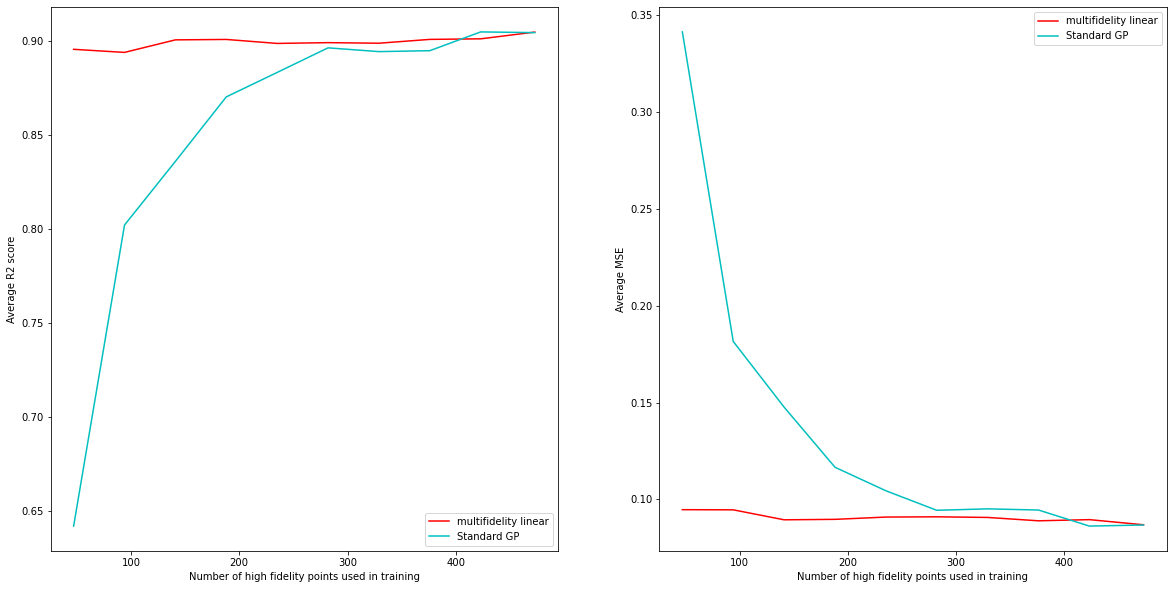

In [26]:
fig,ax =plt.subplots(nrows=1, ncols=2, figsize=(20,10))
ax1, ax2 = ax

ax1.plot(plot_x_training,y_plot('r2_lin_mf'), c ='r', label='Transfer Learning')
ax1.plot(plot_x_training, y_plot('r2_stand_GP'), c ='c', label='Standard GP')
ax1.set_xlabel('Number of high fidelity points used in training')
ax1.set_ylabel('Average R2 score')
ax1.legend()
    
ax2.plot(plot_x_training, y_plot('mse_lin_mf'), c ='r', label='Transfer Learning')
ax2.plot(plot_x_training, y_plot('mse_stand_GP'), c ='c', label='Standard GP')
ax2.set_xlabel('Number of target designs used in training')
ax2.set_ylabel('Average MSE')
ax2.legend()
#save_fig(f'{name}_ARD_PTB')

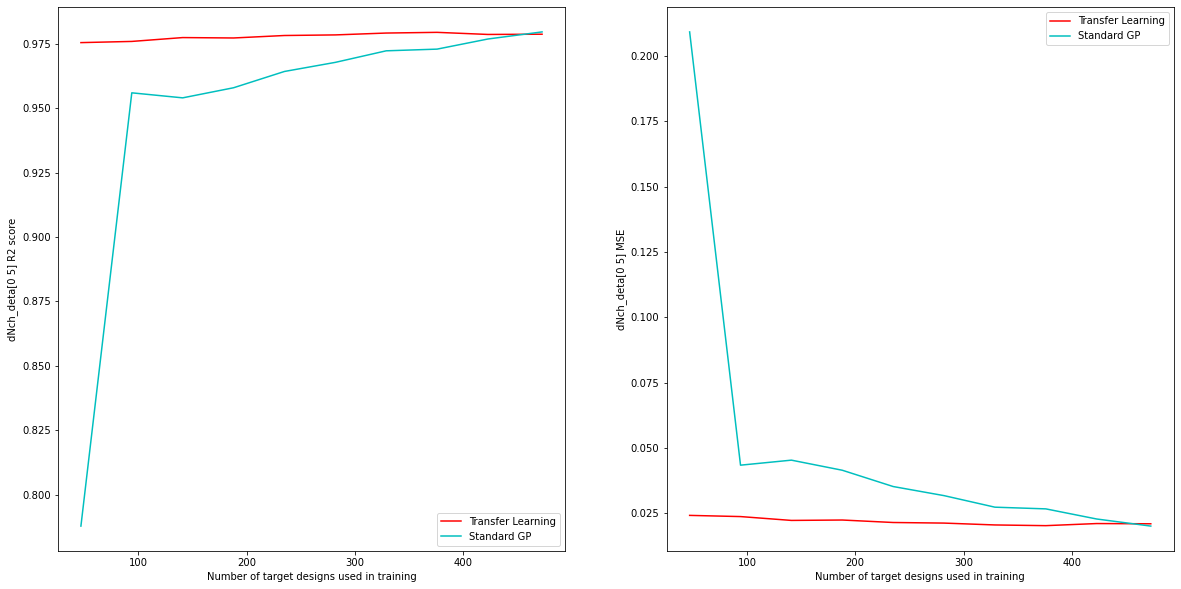

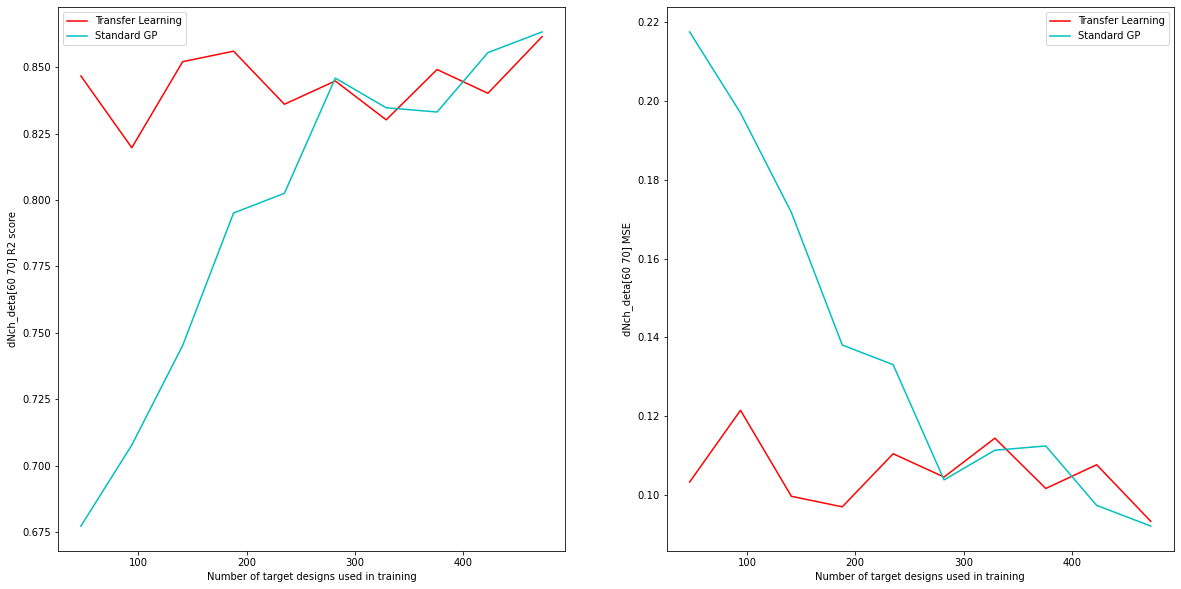

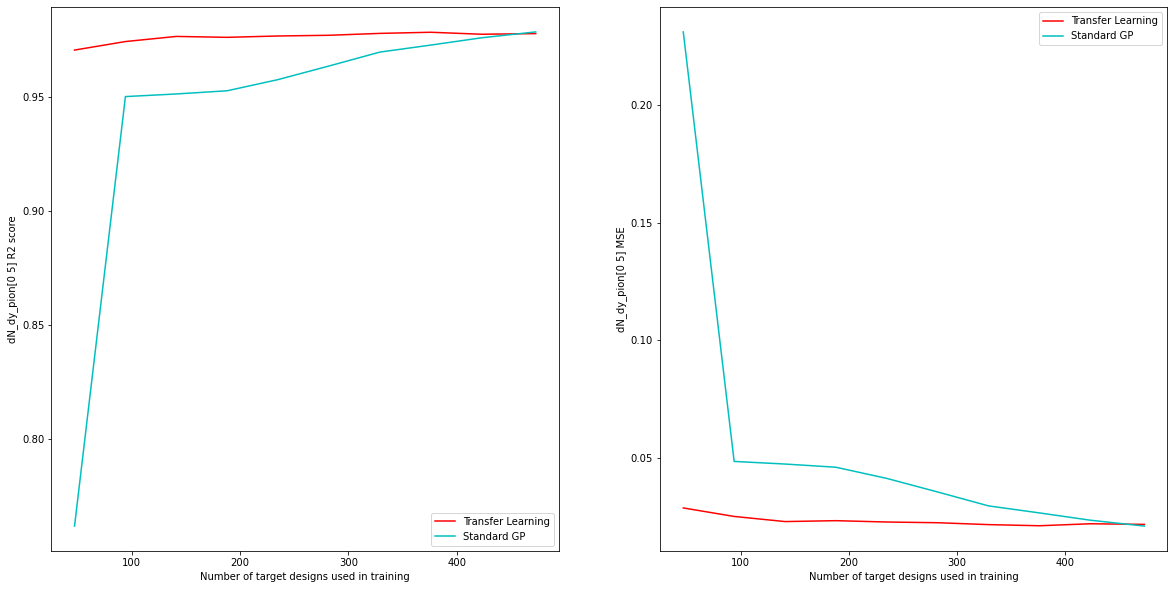

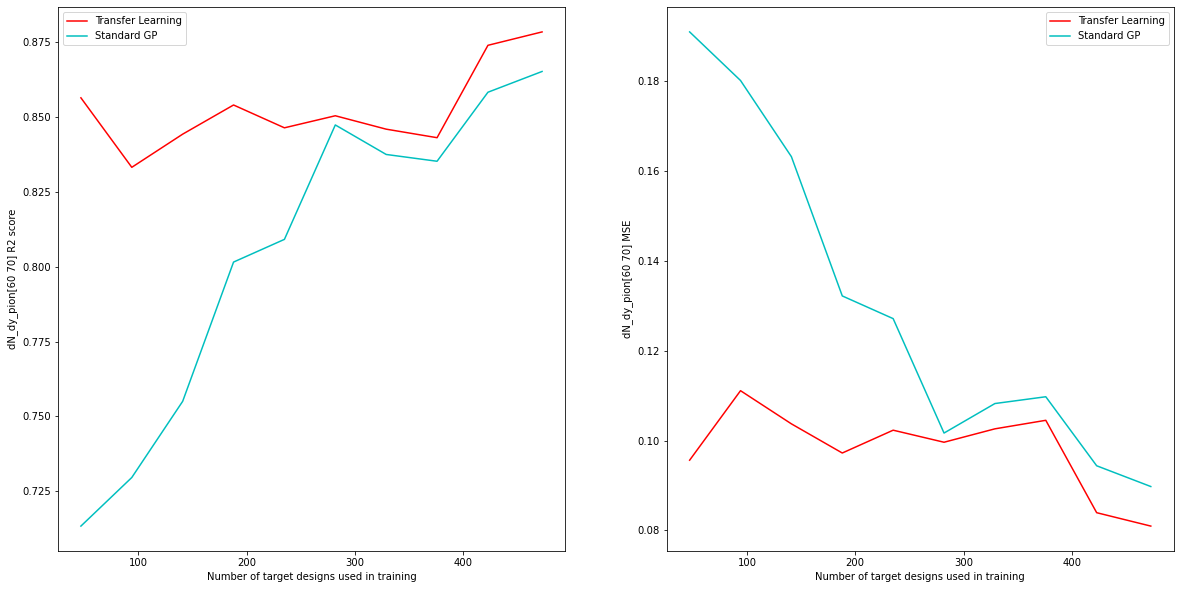

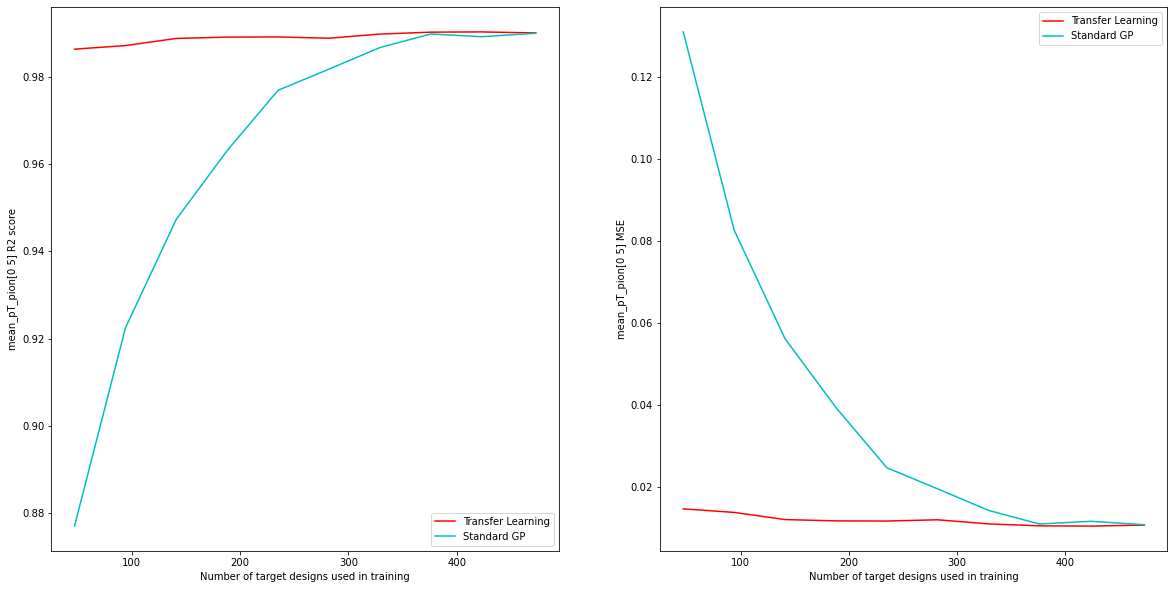

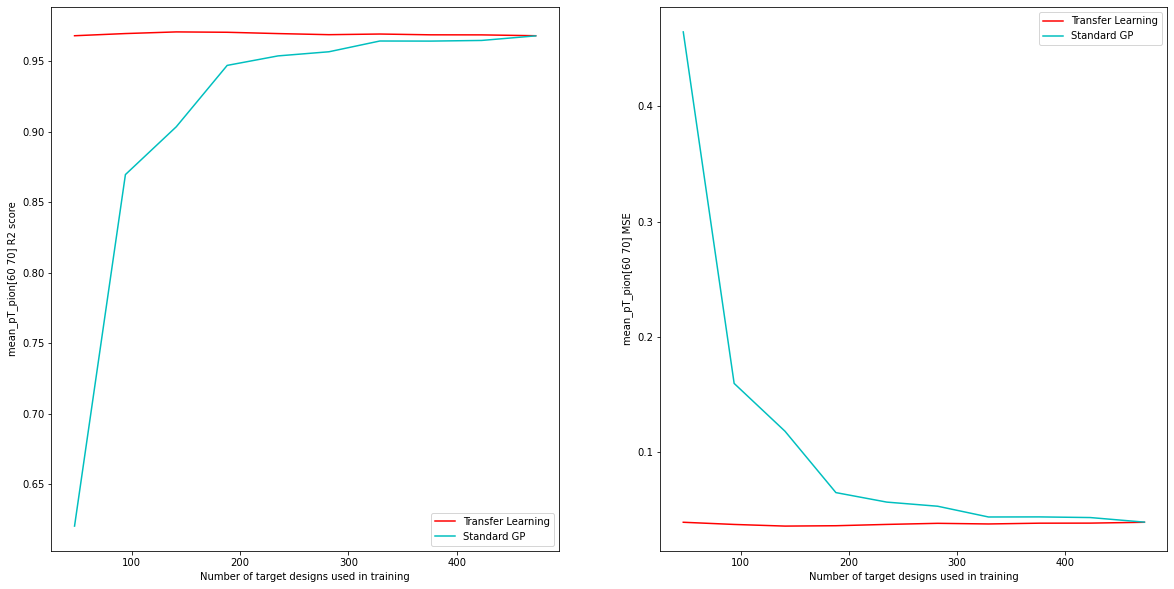

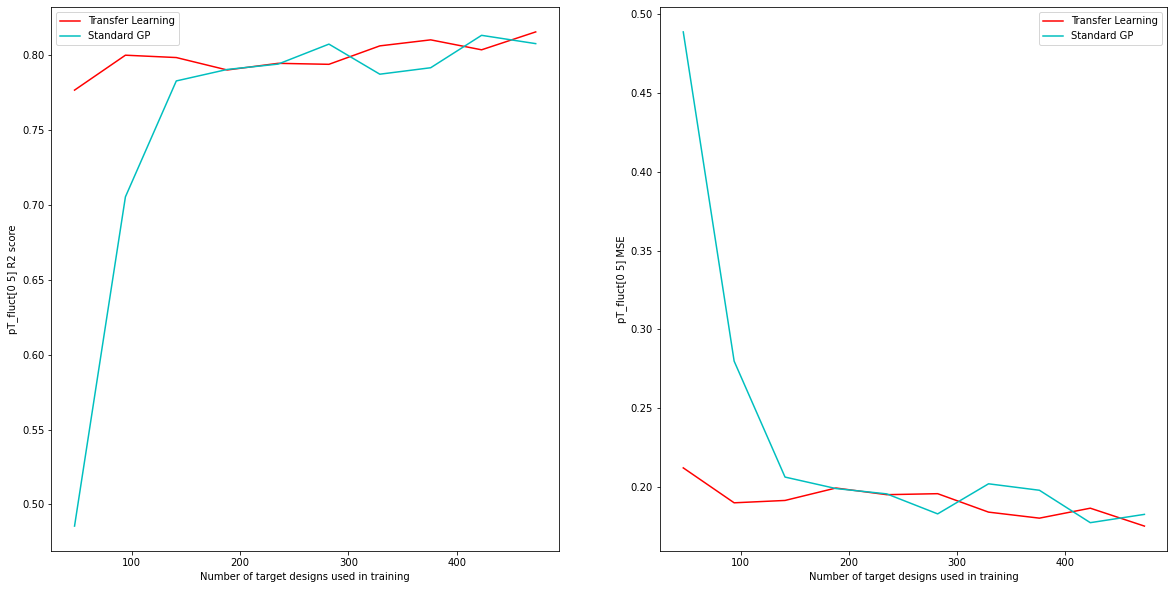

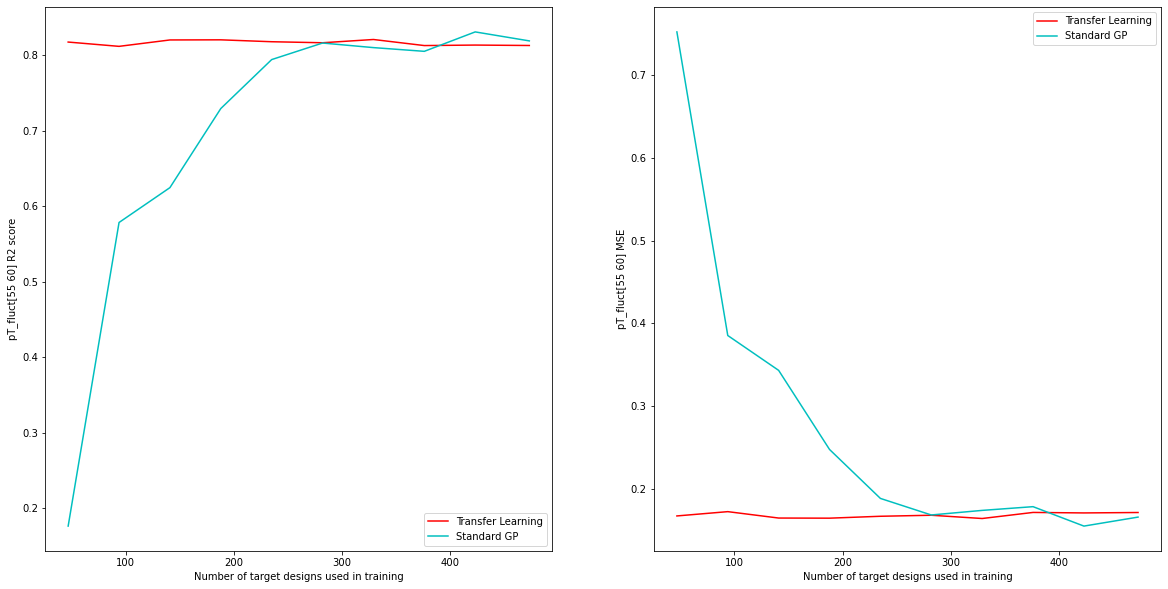

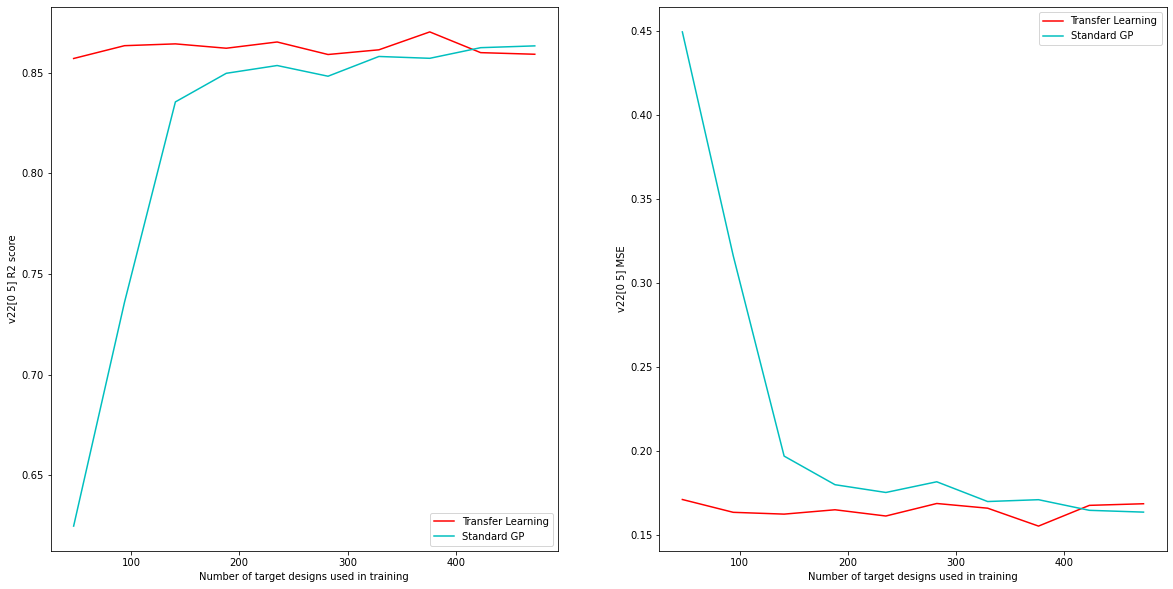

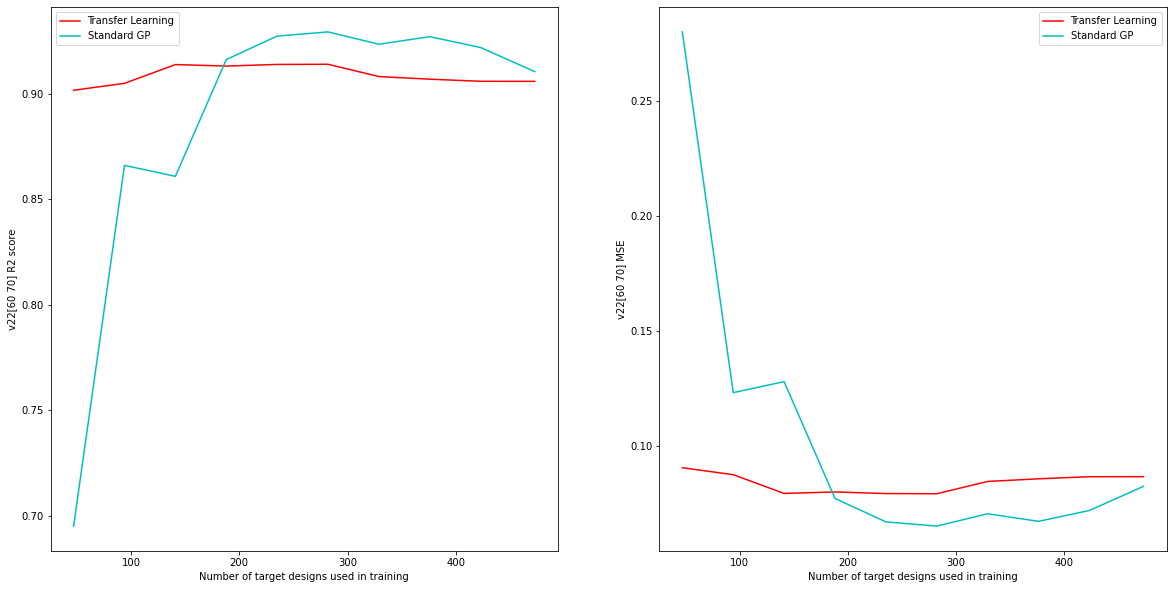

In [28]:
for obs in observables_choosen:
    fig,ax =plt.subplots(nrows=1, ncols=2, figsize=(20,10))
    ax1, ax2 = ax
    ax1.plot(plot_x_training,y_plot_obs('r2_lin_mf',obs), c ='r', label='Transfer Learning')
    ax1.plot(plot_x_training,y_plot_obs('r2_stand_GP',obs),c ='c', label='Standard GP')
    ax1.set_xlabel('Number of target designs used in training')
    ax1.set_ylabel(f'{obs} R2 score')
    ax1.legend()

    ax2.plot(plot_x_training,y_plot_obs('mse_lin_mf',obs), c ='r', label='Transfer Learning')
    ax2.plot(plot_x_training,y_plot_obs('mse_stand_GP',obs), c ='c', label='Standard GP')
    ax2.set_xlabel('Number of target designs used in training')
    ax2.set_ylabel(f'{obs} MSE')
    ax2.legend()
    #save_fig(f'{name}_ARD_PTB')